In [13]:
json_path ="chunked_prefill-qps-1-input-len-128-tp-8.json"
import json

# Open and read the JSON file
with open(json_path, 'r') as file:
    data = json.load(file)

# Print the data
keys = data.keys()
values = data.values() 
print(keys)
print(type(data['date']))

dict_keys(['date', 'backend', 'model_id', 'tokenizer_id', 'num_prompts', 'request_rate', 'burstiness', 'max_concurrency', 'duration', 'completed', 'total_input_tokens', 'total_output_tokens', 'request_throughput', 'request_goodput:', 'output_throughput', 'total_token_throughput', 'input_lens', 'output_lens', 'ttfts', 'prefill_start_ts', 'prefill_start_counter', 'prefill_end_counter', 'prefill_end_ts', 'itls', 'errors', 'mean_ttft_ms', 'median_ttft_ms', 'std_ttft_ms', 'p99_ttft_ms', 'mean_tpot_ms', 'median_tpot_ms', 'std_tpot_ms', 'p99_tpot_ms', 'mean_itl_ms', 'median_itl_ms', 'std_itl_ms', 'p99_itl_ms'])
<class 'str'>


# Aggregate result

In [7]:
import os
import glob
import json
import re
import pandas as pd

# Regex to parse filenames like:
#   chunked_prefill-qps-1-input-len-1024-tp-8.json
FNAME_RE = re.compile(
    r'^(?P<tag>[^-]+)-qps-(?P<qps>\d+)-input-len-(?P<input_len>\d+)-tp-(?P<tp>\d+)\.json$'
)

# Only these metric keys will be extracted from each JSON
METRIC_KEYS = [
    "date",
    "backend",
    "num_prompts",
    "duration",
    "completed",
    "request_throughput",
    "output_throughput",
    "total_token_throughput",
    "mean_ttft_ms",
    "median_ttft_ms",
    "std_ttft_ms",
    "p99_ttft_ms",
    "mean_tpot_ms",
    "median_tpot_ms",
    "std_tpot_ms",
    "p99_tpot_ms",
    "mean_itl_ms",
    "median_itl_ms",
    "std_itl_ms",
    "p99_itl_ms",
]
def parse_filename_attributes(filename):
    base = os.path.basename(filename)
    m = FNAME_RE.match(base)
    if not m:
        raise ValueError(f"Filename {base!r} does not match expected pattern")
    return m.groupdict()

def gather_json_stats(input_folder, output_csv):
    rows = []
    for path in glob.glob(os.path.join(input_folder, '*.json')):
        # 1) filename-derived attributes
        attrs = parse_filename_attributes(path)

        # 2) load JSON and pick only desired metrics
        with open(path, 'r') as f:
            data = json.load(f)
        metrics = {k: data.get(k) for k in METRIC_KEYS}

        # 3) combine and append
        row = {**attrs, **metrics}
        rows.append(row)

    # 4) write out to CSV
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"Wrote {len(rows)} rows to {output_csv}")

if __name__ == '__main__':
    input_folder = '.'
    output_csv   = './all_metrics.csv'
    gather_json_stats(input_folder, output_csv)


Wrote 61 rows to ./all_metrics.csv


               mean_ttft_ms    p99_ttft_ms  mean_tpot_ms  p99_tpot_ms  \
input_len qps                                                           
1024      35   19975.542466   42043.016292    146.817499   228.448337   
2048      50   61822.437271  124670.830460    214.350882   268.324198   
          40   58846.747304  119068.664620    213.989064   267.526727   
          30   54483.948918  110452.473531    214.541375   267.187753   
128       20     157.225487     254.003608     46.569498    54.674969   

               mean_itl_ms  p99_itl_ms  request_throughput  output_throughput  \
input_len qps                                                                   
1024      35    142.746277  259.200159           12.148872        2677.794176   
2048      50    209.344251  290.213928            6.487842        1453.764539   
          40    209.073036  290.435404            6.521726        1468.235518   
          30    209.479444  291.561258            6.506004        1457.834149   
12

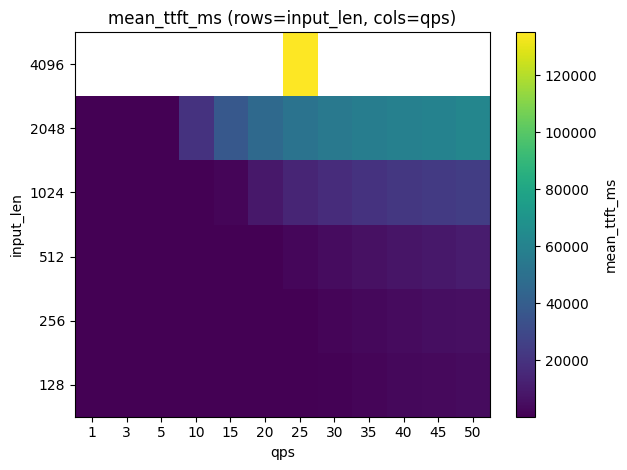

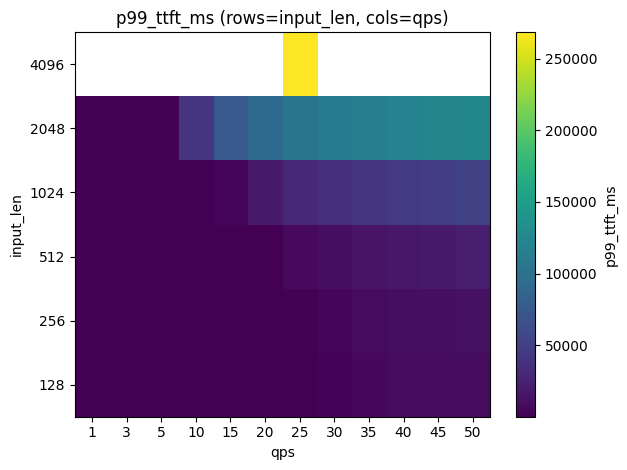

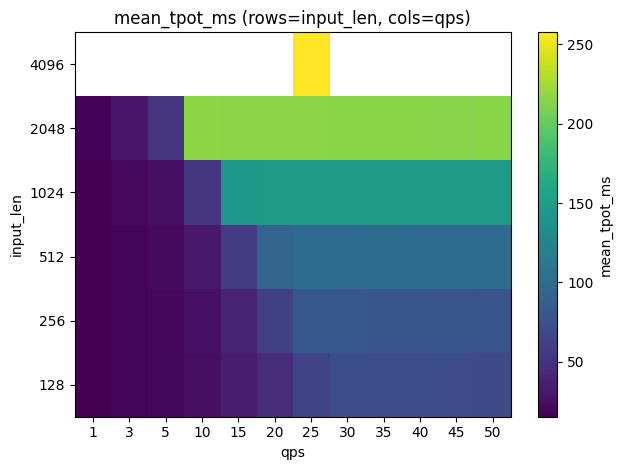

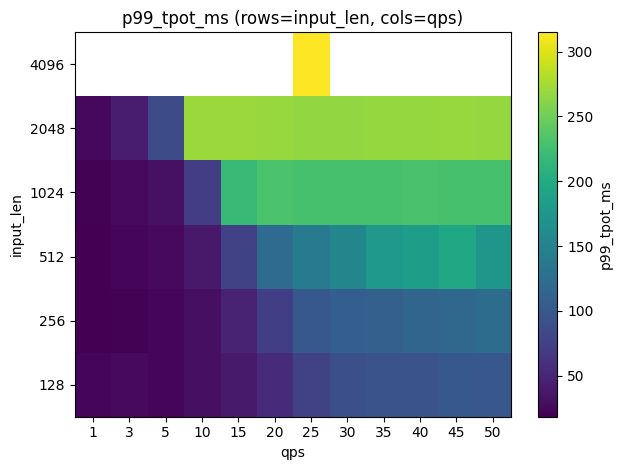

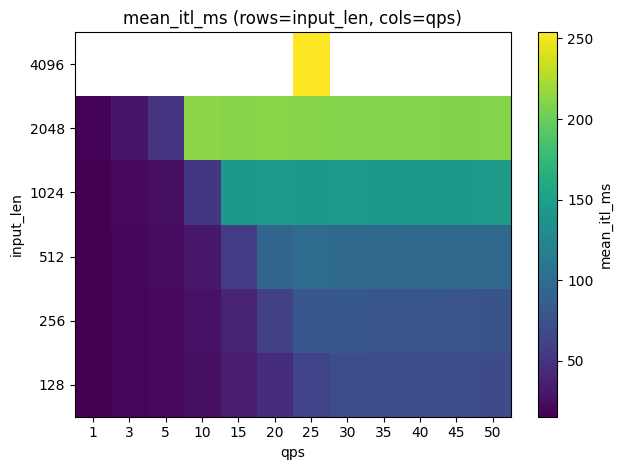

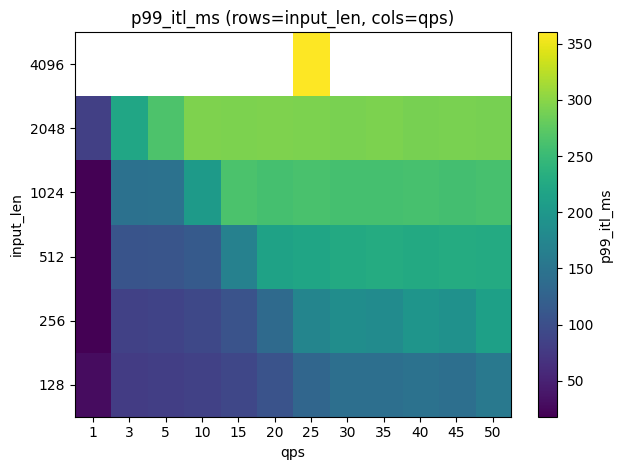

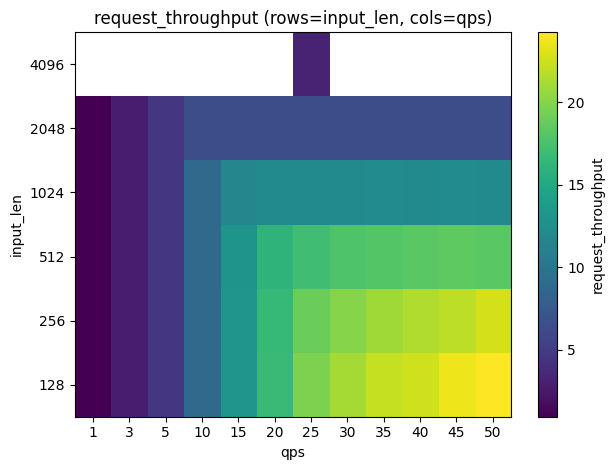

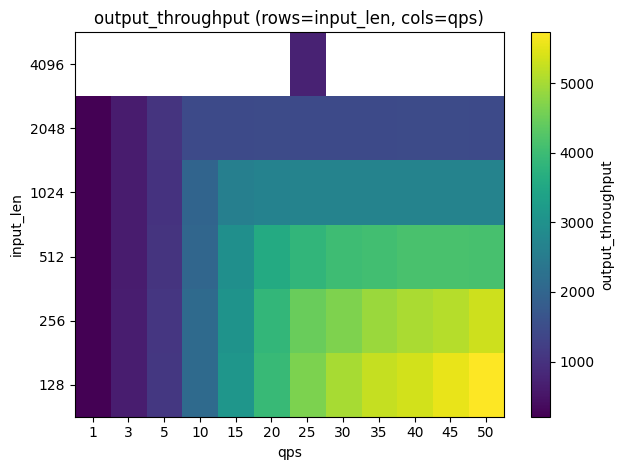

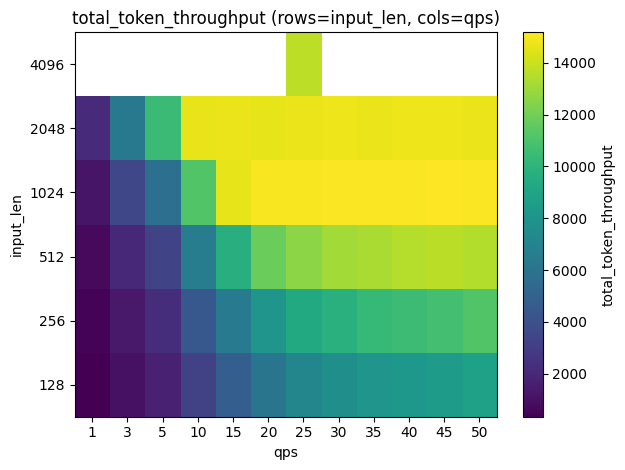

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# List of metrics to include as columns
METRIC_KEYS = [
    "mean_ttft_ms",
    "p99_ttft_ms",
    "mean_tpot_ms",
    "p99_tpot_ms",
    "mean_itl_ms",
    "p99_itl_ms",
    "request_throughput",
    "output_throughput",
    "total_token_throughput",
]

def load_and_pivot(csv_path):
    # 1) Read CSV
    df = pd.read_csv(csv_path)
    
    # 2) Coerce index columns
    df['input_len'] = df['input_len'].astype(int)
    df['qps']       = df['qps'].astype(int)
    
    # 3) Set a MultiIndex of (input_len, qps)
    df = df.set_index(['input_len', 'qps'])
    
    # 4) Keep only metric columns
    pivot = df[METRIC_KEYS]
    return pivot

def plot_heatmap(pivot_df, metric):
    """
    Given the pivoted DataFrame and a single metric name,
    plots a heatmap where rows are input_len, columns are qps.
    """
    data = pivot_df[metric].unstack(level='qps')  # rows=input_len, cols=qps
    plt.figure()
    plt.imshow(data, aspect='auto', origin='lower')
    plt.colorbar(label=metric)
    plt.title(f"{metric} (rows=input_len, cols=qps)")
    plt.xlabel("qps")
    plt.ylabel("input_len")
    plt.xticks(range(data.shape[1]), data.columns)
    plt.yticks(range(data.shape[0]), data.index)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    pivot_df = load_and_pivot("./all_metrics.csv")
    
    # Inspect the pivoted table
    print(pivot_df.head())
    
    # Plot heatmaps for each metric
    for metric in METRIC_KEYS:
        plot_heatmap(pivot_df, metric)


### Decode takes a hit when qps is increased. With Chunked prefill ttft is not affected as bad. Max qps we took for this analysis is 50 so with chunked prefill every batch would have 50 decodes (worst case) + 200

# Timestamp study

In [8]:
import pandas as pd
import numpy as np
import json
import ast
from datetime import datetime, timedelta,timezone

csv_path = '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in128_qps1_chunked_prefill_tp1_0'
json_path = '/var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-1-input-len-128-tp-8.json'

def create_trace(csv_path,json_path,filename=None):

    df = pd.read_csv(csv_path)
    with open(json_path, 'r') as f:
        meta = json.load(f)
    prefill_start_ts_list = meta['prefill_start_ts'] 

    # Prefill COncurreny
    prefill_ends_ts_list = meta['prefill_end_ts']

    prefill_starts_dt = pd.to_datetime(prefill_start_ts_list, unit='s')
    
    prefill_ends_dt = pd.to_datetime(prefill_ends_ts_list, unit='s')

    csv_timestamps = pd.to_datetime(df['timestamp']).to_numpy()

    prefill_starts_dt = np.array(prefill_starts_dt)  # shape (num_prefill,)
    prefill_ends_dt = np.array(prefill_ends_dt)      # shape (num_prefill,)

    prefill_concurrency = ((csv_timestamps[:, None] >= prefill_starts_dt) &
                        (csv_timestamps[:, None] < prefill_ends_dt)).sum(axis=1)
    df['prefill_concurrency'] = prefill_concurrency


    # Get decode timestamps

    prefill_ends = pd.to_datetime(prefill_ends_dt)      # pandas DatetimeIndex, (num_requests,)
    itl = meta['itls']    
    # df['prefill_ends']=prefill_ends                              

    decode_ts = []  # List of lists

    for i, itl_row in enumerate(itl):
        times = []
        t = prefill_ends[i]
        for j, itl_val in enumerate(itl_row):
            times.append(t)
            t = t + timedelta(seconds=itl_val)
        decode_ts.append(times)


    # Algo for decode concurrency
    # 1. Build list of all interval events (start, +1) and (end, -1)
    events = []  # Each event is (time, +1/-1)
    for i, row in enumerate(decode_ts):
        for j in range(1, len(row)):
            events.append((row[j-1], +1))
            events.append((row[j], -1))

    # 2. Prepare CSV timestamps as queries
    csv_times = pd.to_datetime(df['timestamp']).to_numpy()
    csv_events = [(t, 0, idx) for idx, t in enumerate(csv_times)]  # (time, type, original index), type 0 for query

    # 3. Combine and sort all events (decode starts/ends and queries)
    # For sorting: type +1 (start) comes before 0 (query) comes before -1 (end) for same timestamp.
    all_events = []
    for (t, val) in events:
        all_events.append((t, 1 if val == +1 else -1, -1))  # (time, type, -1)
    for (t, typ, idx) in csv_events:
        all_events.append((t, 0, idx))

    # Sort: by time, then by type
    all_events.sort()

    # 4. Sweep through events, updating concurrency, record at each CSV query
    concurrency = np.zeros(len(csv_times), dtype=int)
    curr = 0
    for t, typ, idx in all_events:
        if typ == 1:      # decode start
            curr += 1
        elif typ == -1:   # decode end
            curr -= 1
        else:             # CSV timestamp query
            concurrency[idx] = curr

    df['decode_concurrency'] = concurrency


    # Inflight tokens
    df['prefill_token_inflight'] = np.where(
        df['prefill_concurrency'] > 0,
        2048 - df['decode_concurrency'],
        0
    )
    if filename:
        df.to_csv(filename, index=False)
    else:
        df.to_csv('metrics_with_timestamps.csv', index=False)
    return prefill_starts_dt,prefill_ends_dt
    


In [9]:
csv_path = '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in256_qps50_chunked_prefill_tp8_0'
json_path = '/var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-50-input-len-256-tp-8.json'

prefill_starts_dt,prefill_ends_dt=create_trace(csv_path,json_path,'256_50.csv')

2025-07-09T06:27:30.407814503
2025-07-09T06:27:29.622133970
2025-07-09T06:27:30.593671322
2025-07-09T06:27:29.755528450
2025-07-09T06:27:30.593776464
2025-07-09T06:27:29.868405342
2025-07-09T06:27:30.593712091
2025-07-09T06:27:29.868381500
2025-07-09T06:27:30.593796015
2025-07-09T06:27:29.868435383
2025-07-09T06:27:30.593535185
2025-07-09T06:27:29.868256330
2025-07-09T06:27:30.593597412
2025-07-09T06:27:29.959295988
2025-07-09T06:27:30.593655109
2025-07-09T06:27:29.959447861
2025-07-09T06:27:30.781569242
2025-07-09T06:27:29.959378958
2025-07-09T06:27:30.781479120
2025-07-09T06:27:30.054170132
2025-07-09T06:27:30.781603813
2025-07-09T06:27:30.054259777
2025-07-09T06:27:30.781711578
2025-07-09T06:27:30.247586727
2025-07-09T06:27:30.781666040
2025-07-09T06:27:30.247554779
2025-07-09T06:27:30.781749487
2025-07-09T06:27:30.270770073
2025-07-09T06:27:30.781387329
2025-07-09T06:27:30.270233393
2025-07-09T06:27:30.949487686
2025-07-09T06:27:30.270493507
2025-07-09T06:27:30.949630976
2025-07-09

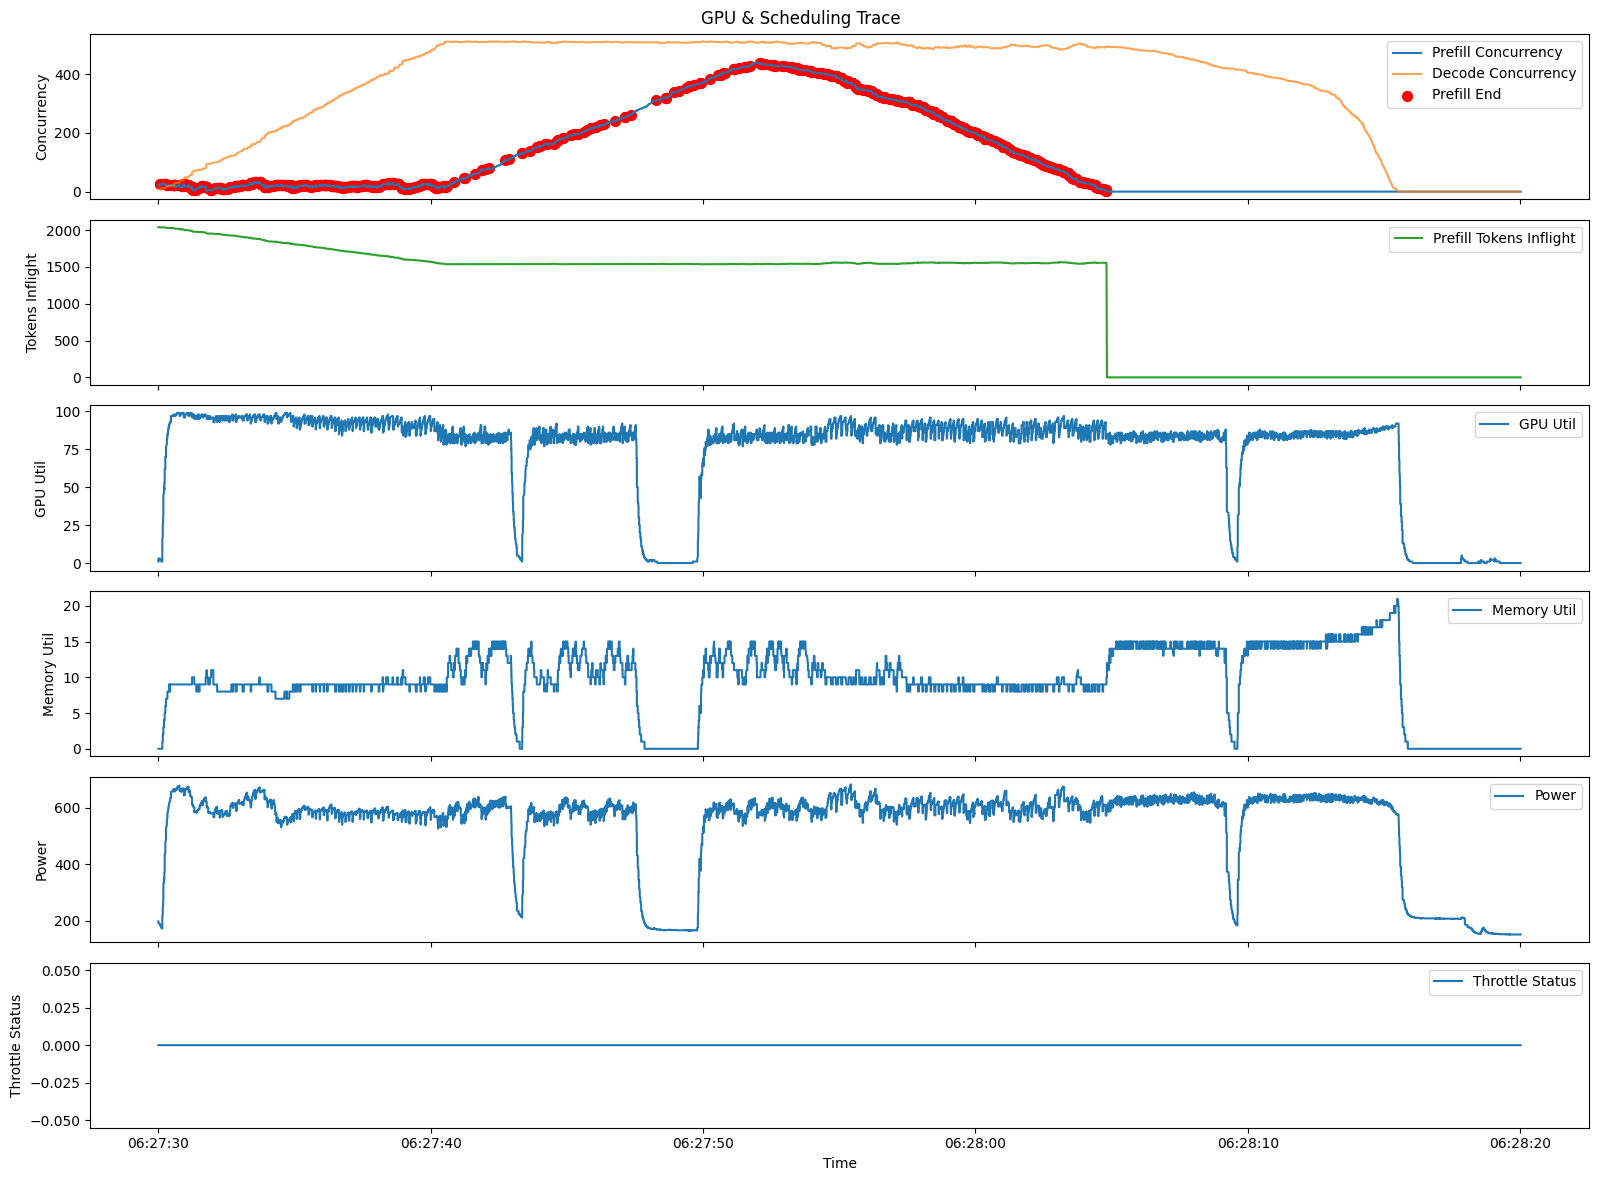

In [24]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

def plot_gpu_trace_with_prefill_dots(
    csv_path,
    json_path,
    start_time=None,
    end_time=None,
    metrics_to_plot=None,
    metric_labels=None,
    title="",
):
    # Load CSV
    df = pd.read_csv(csv_path)
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Load JSON
    with open(json_path) as f:
        meta = json.load(f)

    # Get prefill start/end timestamps as arrays
    prefill_start_ts_list = meta['prefill_start_ts']
    prefill_end_ts_list = meta['prefill_end_ts']
    prefill_starts_dt = pd.to_datetime(prefill_start_ts_list, unit='s')
    prefill_ends_dt = pd.to_datetime(prefill_end_ts_list, unit='s')

    # Filter by time range if specified
    if start_time is not None:
        df = df[df['timestamp'] >= pd.to_datetime(start_time)]
    if end_time is not None:
        df = df[df['timestamp'] <= pd.to_datetime(end_time)]

    # Calculate prefill concurrency (if not in df)
    # Ensure all arrays are numpy datetime64[ns] for comparison
    csv_timestamps = pd.to_datetime(df['timestamp']).to_numpy(dtype='datetime64[ns]')
    prefill_starts_dt = pd.to_datetime(prefill_start_ts_list, unit='s').to_numpy(dtype='datetime64[ns]')
    prefill_ends_dt = pd.to_datetime(prefill_end_ts_list, unit='s').to_numpy(dtype='datetime64[ns]')

    csv_timestamps = df['timestamp'].to_numpy()
    prefill_concurrency = (
        (csv_timestamps[:, None] >= np.array(prefill_starts_dt)) &
        (csv_timestamps[:, None] < np.array(prefill_ends_dt))
    ).sum(axis=1)
    df['prefill_concurrency'] = prefill_concurrency

    if metrics_to_plot is None:
        metrics_to_plot = []
    n_metrics = len(metrics_to_plot)
    n_axes = 2 + n_metrics

    fig, axs = plt.subplots(n_axes, 1, figsize=(16, 2 * n_axes), sharex=True)

    # Plot concurrency (ax0)
    axs[0].plot(df['timestamp'], df['prefill_concurrency'], label='Prefill Concurrency')
    axs[0].plot(df['timestamp'], df['decode_concurrency'], label='Decode Concurrency', alpha=0.7)
    axs[0].set_ylabel('Concurrency')

    # --- Plot dots at each prefill end ---
    # Find the concurrency value at each prefill end timestamp (using nearest CSV timestamp <= prefill_end)
    dot_x = []
    dot_y = []
    for ts in prefill_ends_dt:
        print(ts)
        # Find the last CSV timestamp before or equal to this prefill_end
        idx = np.searchsorted(df['timestamp'].values, ts, side='right') - 1
        if 0 <= idx < len(df):
            dot_x.append(df['timestamp'].iloc[idx])
            dot_y.append(df['prefill_concurrency'].iloc[idx])
    axs[0].scatter(dot_x, dot_y, color='red', marker='o', s=50, label='Prefill End')

    axs[0].legend()

    # Plot tokens inflight (ax1)
    axs[1].plot(df['timestamp'], df['prefill_token_inflight'], label='Prefill Tokens Inflight', color='tab:green')
    axs[1].set_ylabel('Tokens Inflight')
    axs[1].legend()

    # Plot user-selected metrics
    for i, col in enumerate(metrics_to_plot):
        label = metric_labels[i] if metric_labels and i < len(metric_labels) else col
        axs[2 + i].plot(df['timestamp'], df[col], label=label)
        axs[2 + i].set_ylabel(label)
        axs[2 + i].legend()

    plt.xlabel('Time')
    plt.suptitle(f'GPU & Scheduling Trace {title}')
    plt.tight_layout()
    plt.show()

plot_gpu_trace_with_prefill_dots(
    "256_50.csv",
    "/var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-50-input-len-256-tp-8.json",
    start_time='2025-07-09T06:27:30',
    metrics_to_plot=['avg_gfx_activ', 'avg_umc_activ', 'curr_power', 'throttle_status'],
    metric_labels=['GPU Util', 'Memory Util', 'Power', 'Throttle Status']
)


In [29]:
import os

def run_trace_and_plot_all(
    results_dir_csv,
    results_dir_json,
    fixed_length=None, vary_qps=None,   # For "fix length, vary QPS"
    fixed_qps=None, vary_length=None,   # For "fix QPS, vary length"
    modes=['chunked_prefill', 'disagg_prefill', 'vllm_prefill'],
    tp=8,
    metrics_to_plot=['avg_gfx_activ', 'avg_umc_activ', 'curr_power', 'throttle_status'],
    metric_labels=['GPU Util', 'Memory Util', 'Power', 'Throttle Status'],
    start_time=None,
    gpus=[0,4]
):
    if fixed_length is not None and vary_qps is not None:
        for qps in vary_qps:
            for mode in modes:
                for gpu in gpus:
                    csv = os.path.join(results_dir_csv, f"in{fixed_length}_qps{qps}_{mode}_tp{tp}_{gpu}")
                    jsn = os.path.join(results_dir_json, f"{mode}-qps-{qps}-input-len-{fixed_length}-tp-{tp}.json")
                    print(f"Running: {csv}, {jsn}")
                    try:
                        create_trace(csv, jsn, filename=csv)
                        plot_gpu_trace_with_prefill_dots(
                            csv, jsn,
                            start_time=start_time,
                            metrics_to_plot=metrics_to_plot,
                            metric_labels=metric_labels,
                            title=f"mode={mode}, qps={qps}, input len={fixed_length}, output len=256, tp={tp}, gpu ={gpu}",
                        )
                    except Exception as e:
                        print(f"Failed for {csv}: {e}")
    elif fixed_qps is not None and vary_length is not None:
        for length in vary_length:
            for mode in modes:
                for gpu in gpus:
                    csv = os.path.join(results_dir_csv, f"in{fixed_length}_qps{qps}_{mode}_tp{tp}_{gpu}")
                    jsn = os.path.join(results_dir_json, f"{mode}-qps-{fixed_qps}-input-len-{length}-tp-{tp}.json")
                    print(f"Running: {csv}, {jsn}")
                    try:
                        create_trace(csv, jsn, filename=csv)
                        plot_gpu_trace_with_prefill_dots(
                            csv, jsn,
                            start_time=start_time,
                            metrics_to_plot=metrics_to_plot,
                            metric_labels=metric_labels,
                            title=f"mode={mode}, qps={fixed_qps}, input len={length}, output len=256, tp={tp}, gpu={gpu}",
                        )
                    except Exception as e:
                        print(f"Failed for {csv}: {e}")
    else:
        print("You must provide either fixed_length+vary_qps or fixed_qps+vary_length.")


Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_chunked_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-1-input-len-4096-tp-8.json
2025-07-09T21:09:14.809325218
2025-07-09T21:09:15.269610167
2025-07-09T21:09:16.038365364
2025-07-09T21:09:18.589549780
2025-07-09T21:09:18.694327354
2025-07-09T21:09:19.203574896
2025-07-09T21:09:19.237899780
2025-07-09T21:09:19.731055021
2025-07-09T21:09:20.628032684
2025-07-09T21:09:20.969027996
2025-07-09T21:09:21.204111576
2025-07-09T21:09:21.516152619
2025-07-09T21:09:22.189900875
2025-07-09T21:09:23.368270397
2025-07-09T21:09:24.482064962
2025-07-09T21:09:27.458542109
2025-07-09T21:09:27.459310055
2025-07-09T21:09:28.504387617
2025-07-09T21:09:29.432766438
2025-07-09T21:09:30.309844971
2025-07-09T21:09:33.598498344
2025-07-09T21:09:33.626992941
2025-07-09T21:09:34.805673838
2025-07-09T21:09:36.492566586
2025-07-09T21:09:37.215963602
2025-07-09T21:09:37.611009598
2025-07-09T21:09:

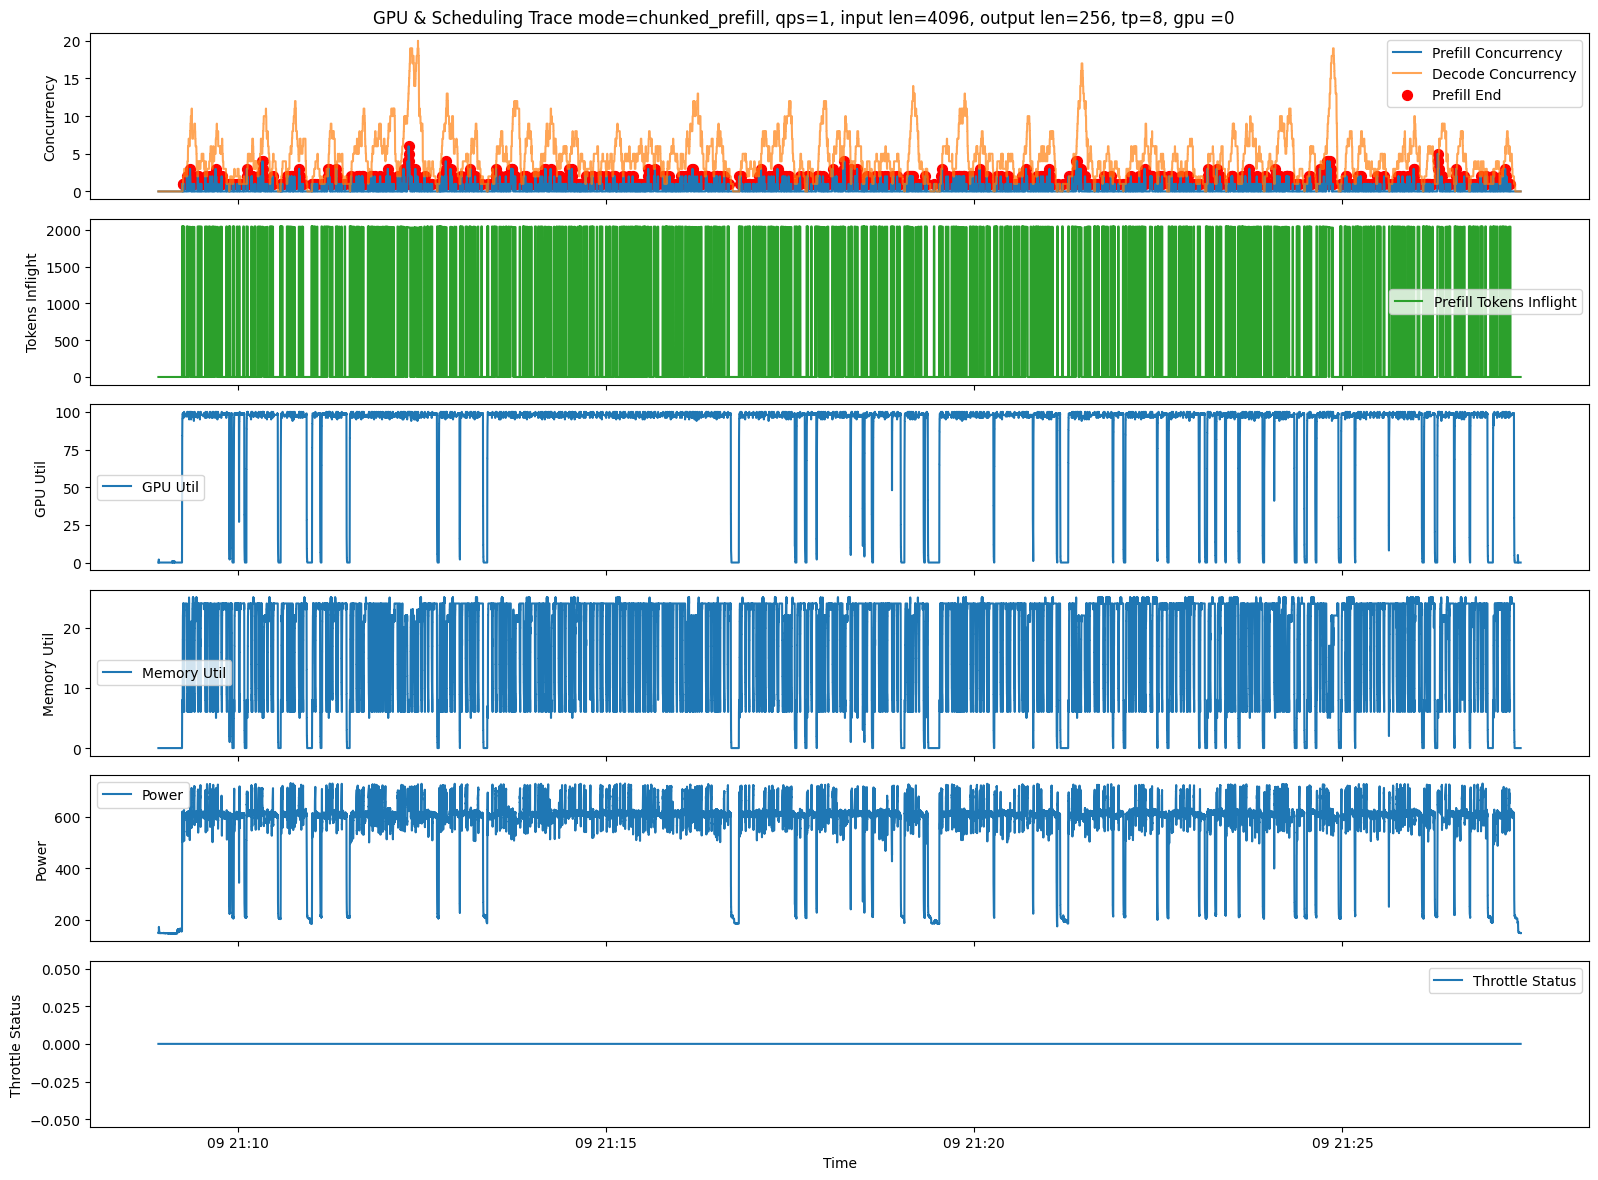

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_chunked_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-1-input-len-4096-tp-8.json
2025-07-09T21:09:14.809325218
2025-07-09T21:09:15.269610167
2025-07-09T21:09:16.038365364
2025-07-09T21:09:18.589549780
2025-07-09T21:09:18.694327354
2025-07-09T21:09:19.203574896
2025-07-09T21:09:19.237899780
2025-07-09T21:09:19.731055021
2025-07-09T21:09:20.628032684
2025-07-09T21:09:20.969027996
2025-07-09T21:09:21.204111576
2025-07-09T21:09:21.516152619
2025-07-09T21:09:22.189900875
2025-07-09T21:09:23.368270397
2025-07-09T21:09:24.482064962
2025-07-09T21:09:27.458542109
2025-07-09T21:09:27.459310055
2025-07-09T21:09:28.504387617
2025-07-09T21:09:29.432766438
2025-07-09T21:09:30.309844971
2025-07-09T21:09:33.598498344
2025-07-09T21:09:33.626992941
2025-07-09T21:09:34.805673838
2025-07-09T21:09:36.492566586
2025-07-09T21:09:37.215963602
2025-07-09T21:09:37.611009598
2025-07-09T21:09:

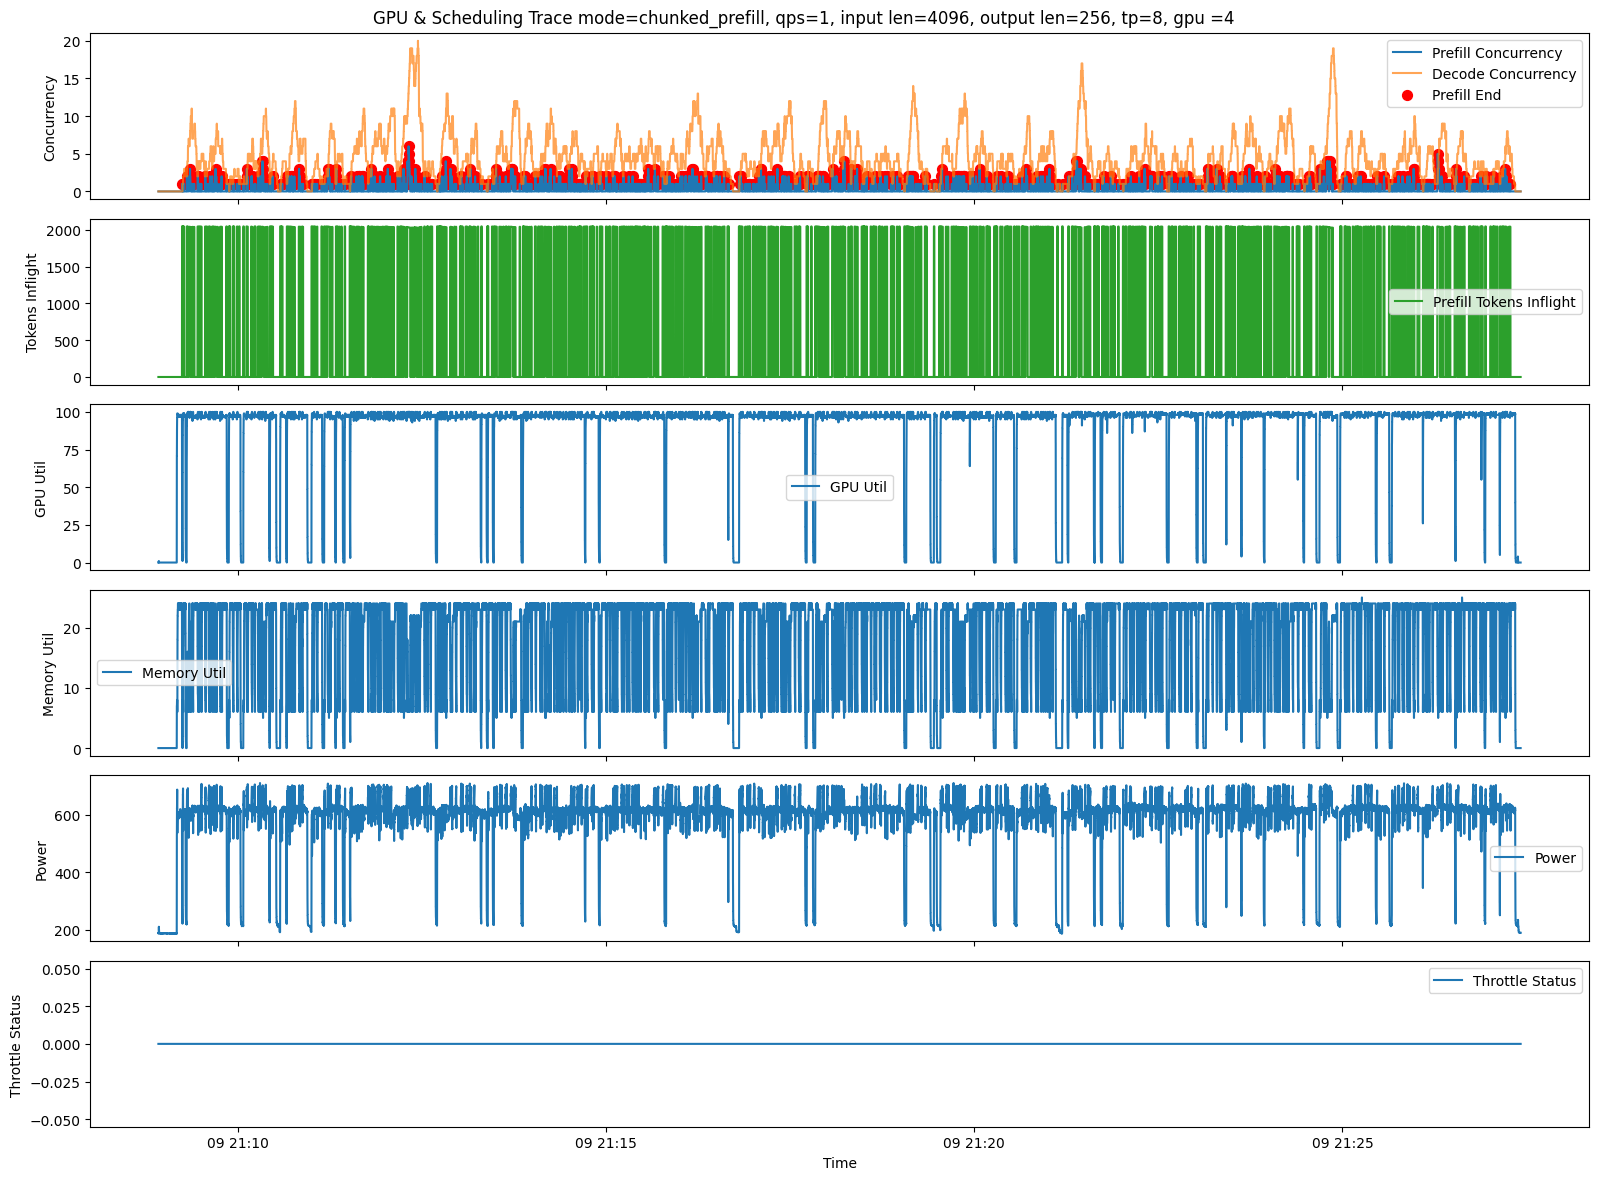

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_disagg_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-1-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_disagg_prefill_tp8_0: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_disagg_prefill_tp8_0'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_disagg_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-1-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_disagg_prefill_tp8_4: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_disagg_prefill_tp8_4'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/

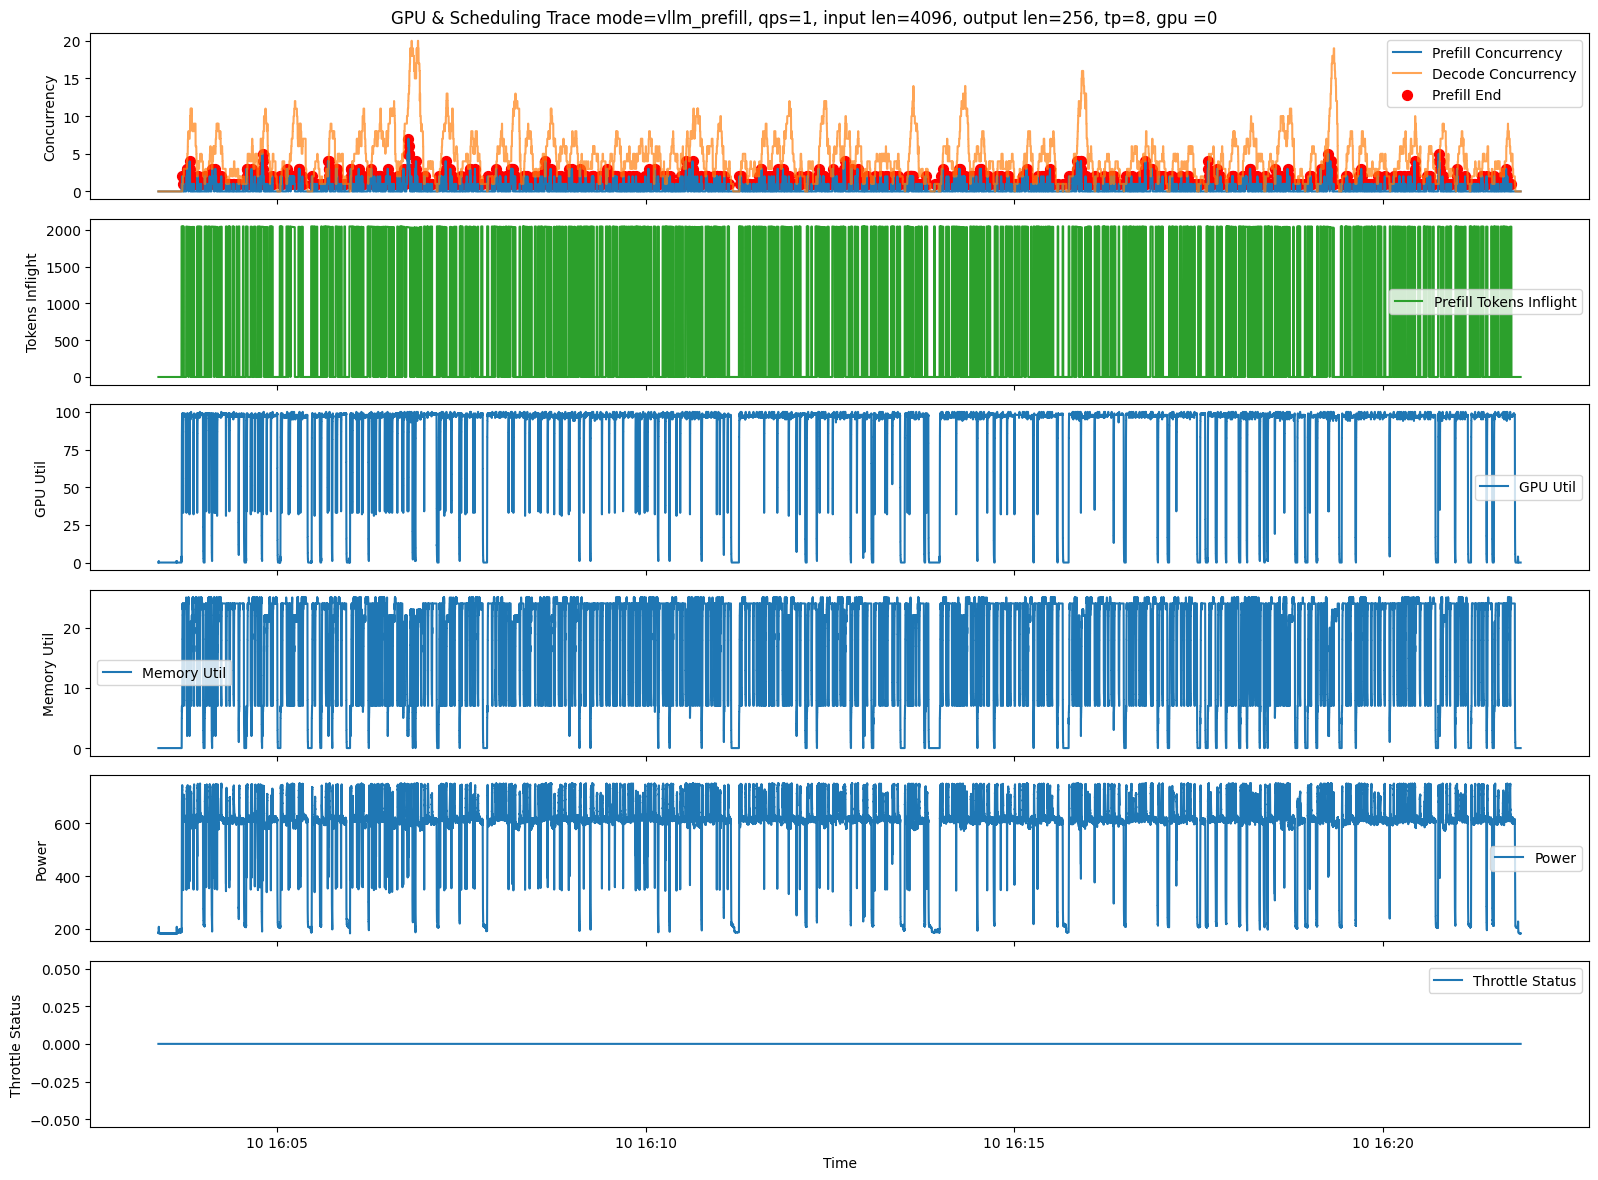

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps1_vllm_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/vllm_prefill-qps-1-input-len-4096-tp-8.json
2025-07-10T16:03:42.586673498
2025-07-10T16:03:43.052133322
2025-07-10T16:03:43.793755293
2025-07-10T16:03:46.370097399
2025-07-10T16:03:46.646128893
2025-07-10T16:03:47.134061574
2025-07-10T16:03:47.035367250
2025-07-10T16:03:47.551912785
2025-07-10T16:03:48.608796358
2025-07-10T16:03:48.908047199
2025-07-10T16:03:48.985105753
2025-07-10T16:03:49.322190762
2025-07-10T16:03:49.841197729
2025-07-10T16:03:51.135255337
2025-07-10T16:03:52.254939556
2025-07-10T16:03:55.230512619
2025-07-10T16:03:55.235898733
2025-07-10T16:03:56.275136232
2025-07-10T16:03:57.092845678
2025-07-10T16:03:58.075419188
2025-07-10T16:04:01.261505365
2025-07-10T16:04:01.380368948
2025-07-10T16:04:02.578011990
2025-07-10T16:04:04.268537521
2025-07-10T16:04:04.993662357
2025-07-10T16:04:05.378247261
2025-07-10T16:04:07.594

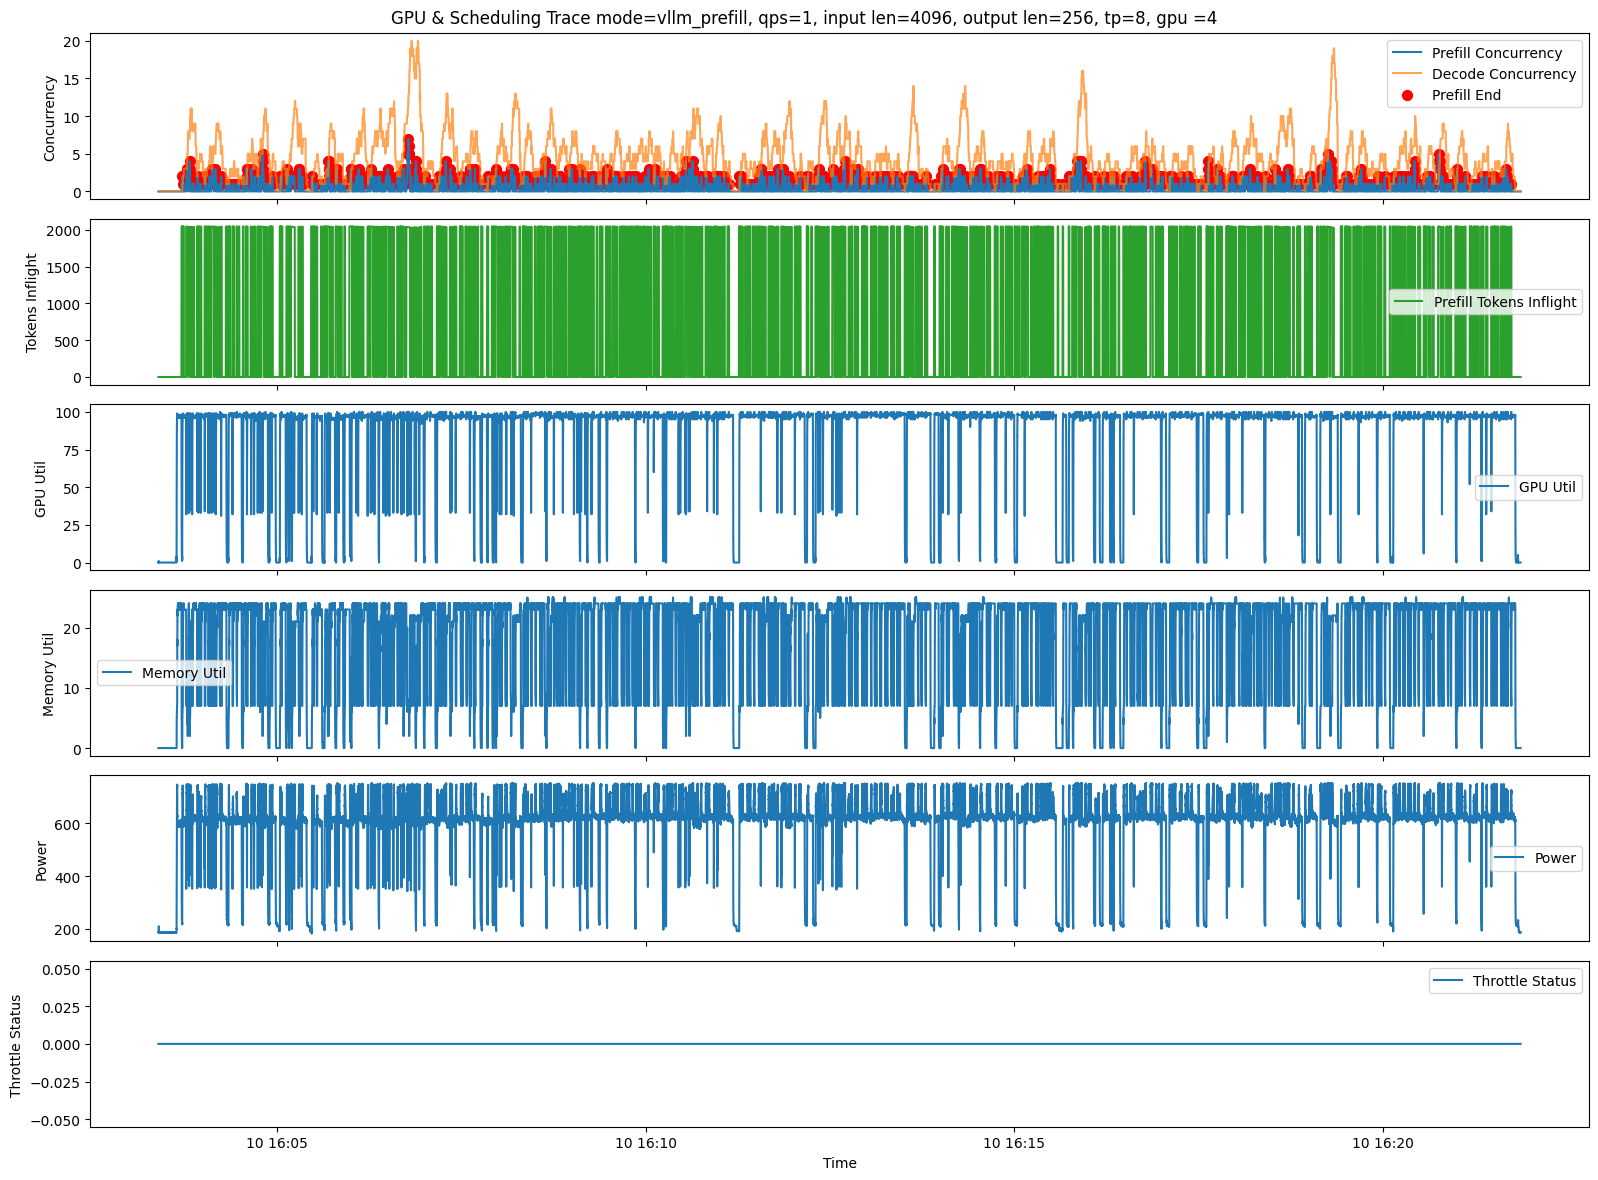

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_chunked_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-10-input-len-4096-tp-8.json
2025-07-09T19:27:07.996318102
2025-07-09T19:27:08.033236980
2025-07-09T19:27:08.544754744
2025-07-09T19:27:08.576601744
2025-07-09T19:27:09.069577932
2025-07-09T19:27:09.106722116
2025-07-09T19:27:09.585803032
2025-07-09T19:27:09.624923706
2025-07-09T19:27:10.038228273
2025-07-09T19:27:10.077884674
2025-07-09T19:27:10.541747808
2025-07-09T19:27:10.527691841
2025-07-09T19:27:11.029978275
2025-07-09T19:27:11.021789074
2025-07-09T19:27:11.507874250
2025-07-09T19:27:11.501918553
2025-07-09T19:27:12.289671898
2025-07-09T19:27:11.974706888
2025-07-09T19:27:12.832147598
2025-07-09T19:27:12.748364210
2025-07-09T19:27:13.361932039
2025-07-09T19:27:13.284485340
2025-07-09T19:27:13.875010967
2025-07-09T19:27:13.809177637
2025-07-09T19:27:14.327028036
2025-07-09T19:27:14.324344397
2025-07-09T19:2

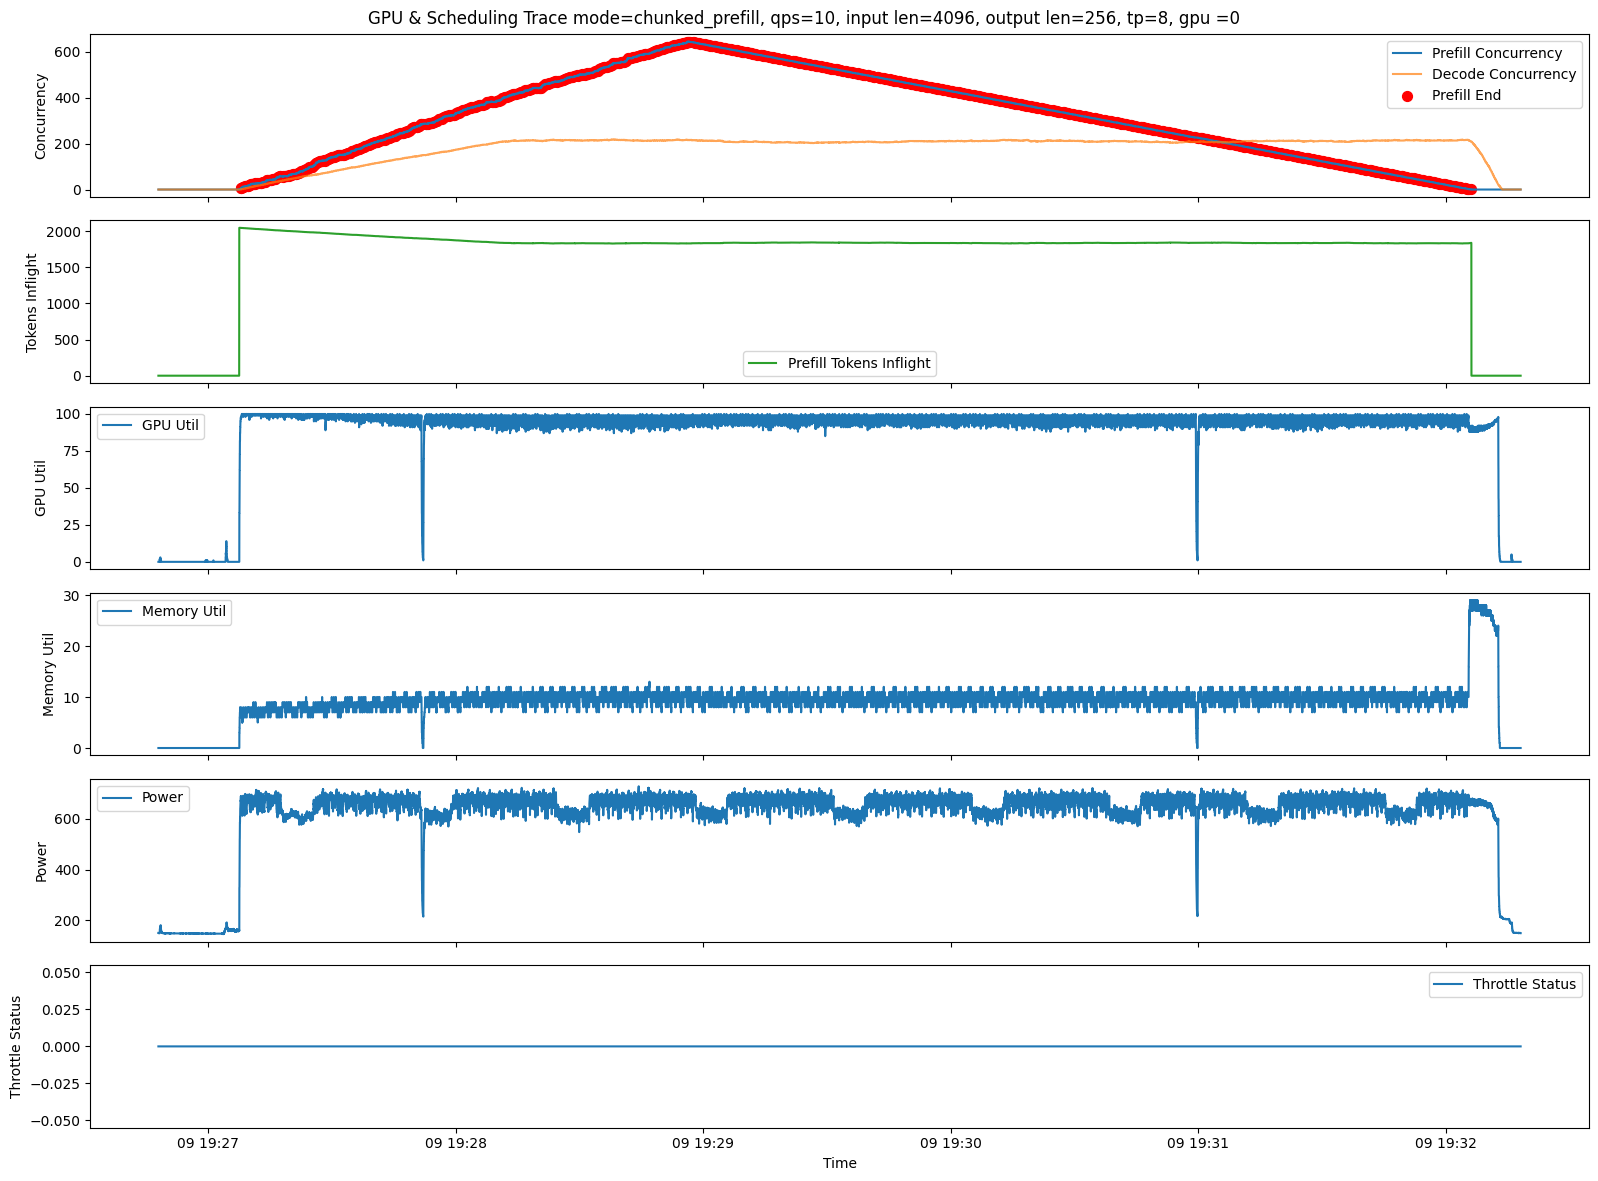

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_chunked_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-10-input-len-4096-tp-8.json
2025-07-09T19:27:07.996318102
2025-07-09T19:27:08.033236980
2025-07-09T19:27:08.544754744
2025-07-09T19:27:08.576601744
2025-07-09T19:27:09.069577932
2025-07-09T19:27:09.106722116
2025-07-09T19:27:09.585803032
2025-07-09T19:27:09.624923706
2025-07-09T19:27:10.038228273
2025-07-09T19:27:10.077884674
2025-07-09T19:27:10.541747808
2025-07-09T19:27:10.527691841
2025-07-09T19:27:11.029978275
2025-07-09T19:27:11.021789074
2025-07-09T19:27:11.507874250
2025-07-09T19:27:11.501918553
2025-07-09T19:27:12.289671898
2025-07-09T19:27:11.974706888
2025-07-09T19:27:12.832147598
2025-07-09T19:27:12.748364210
2025-07-09T19:27:13.361932039
2025-07-09T19:27:13.284485340
2025-07-09T19:27:13.875010967
2025-07-09T19:27:13.809177637
2025-07-09T19:27:14.327028036
2025-07-09T19:27:14.324344397
2025-07-09T19:2

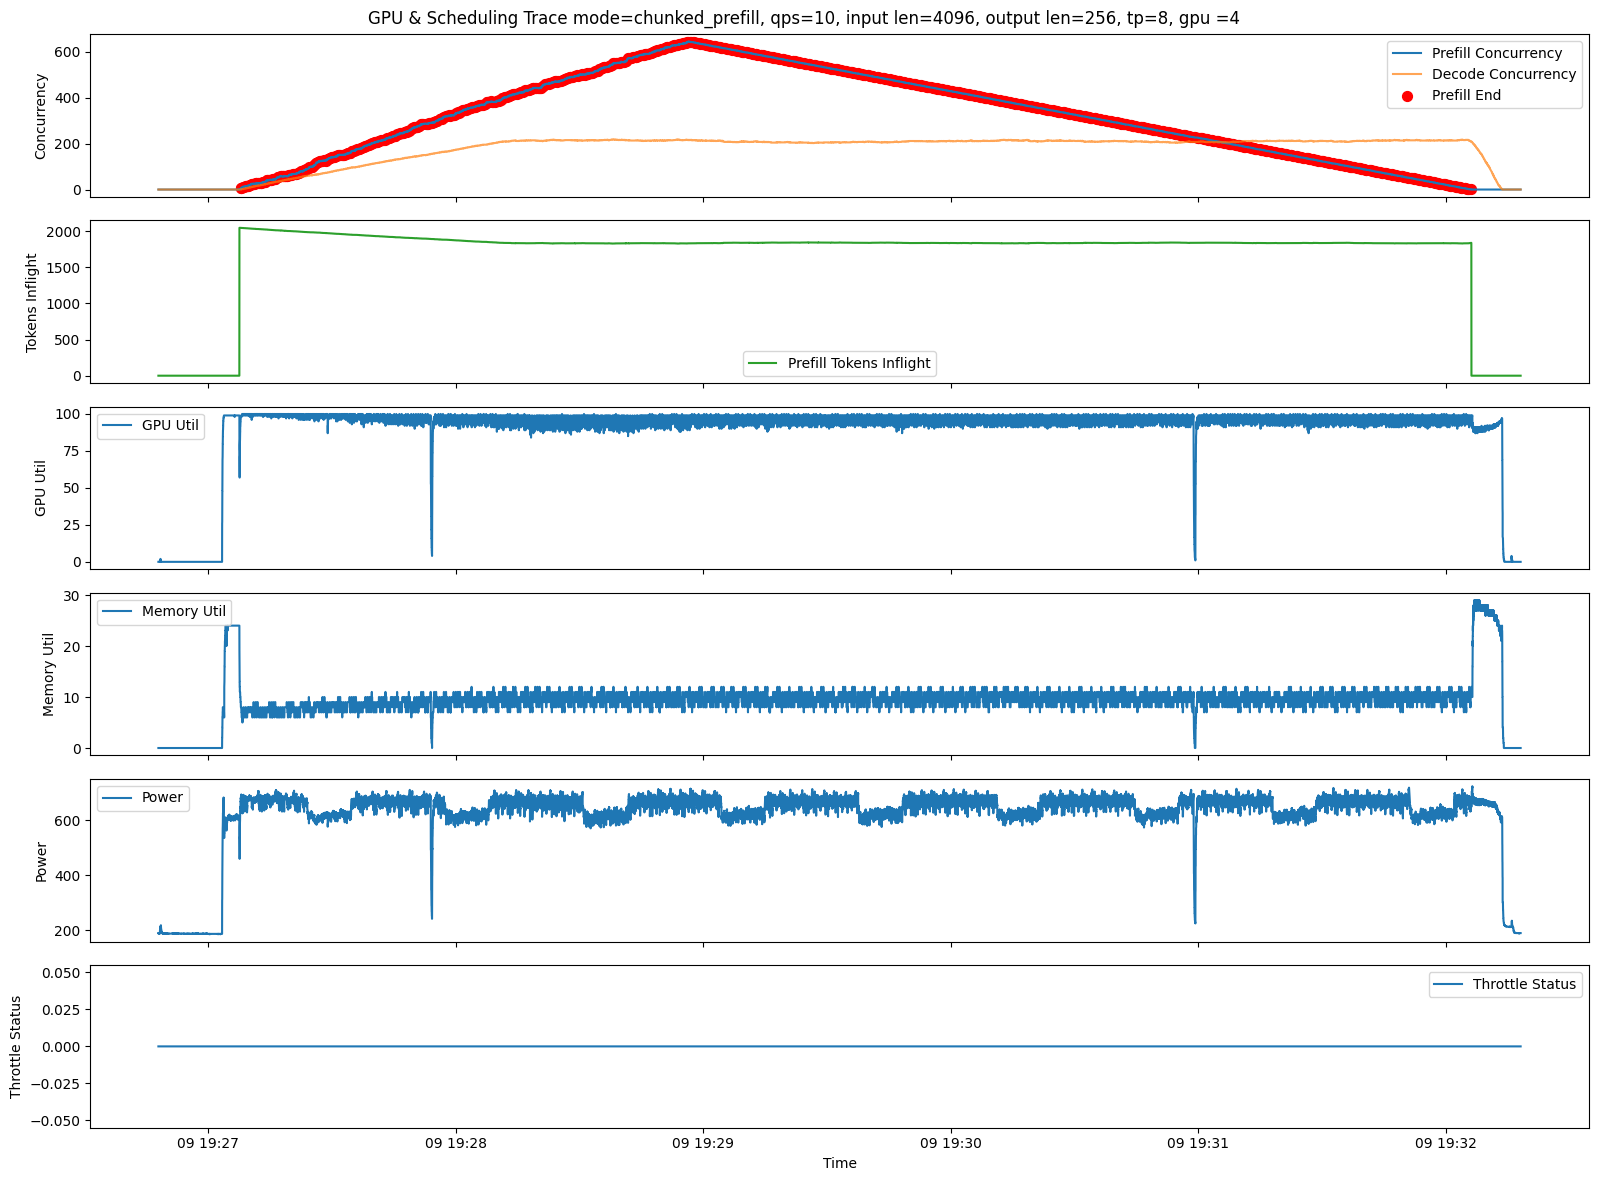

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_disagg_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-10-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_disagg_prefill_tp8_0: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_disagg_prefill_tp8_0'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_disagg_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-10-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_disagg_prefill_tp8_4: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_disagg_prefill_tp8_4'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profili

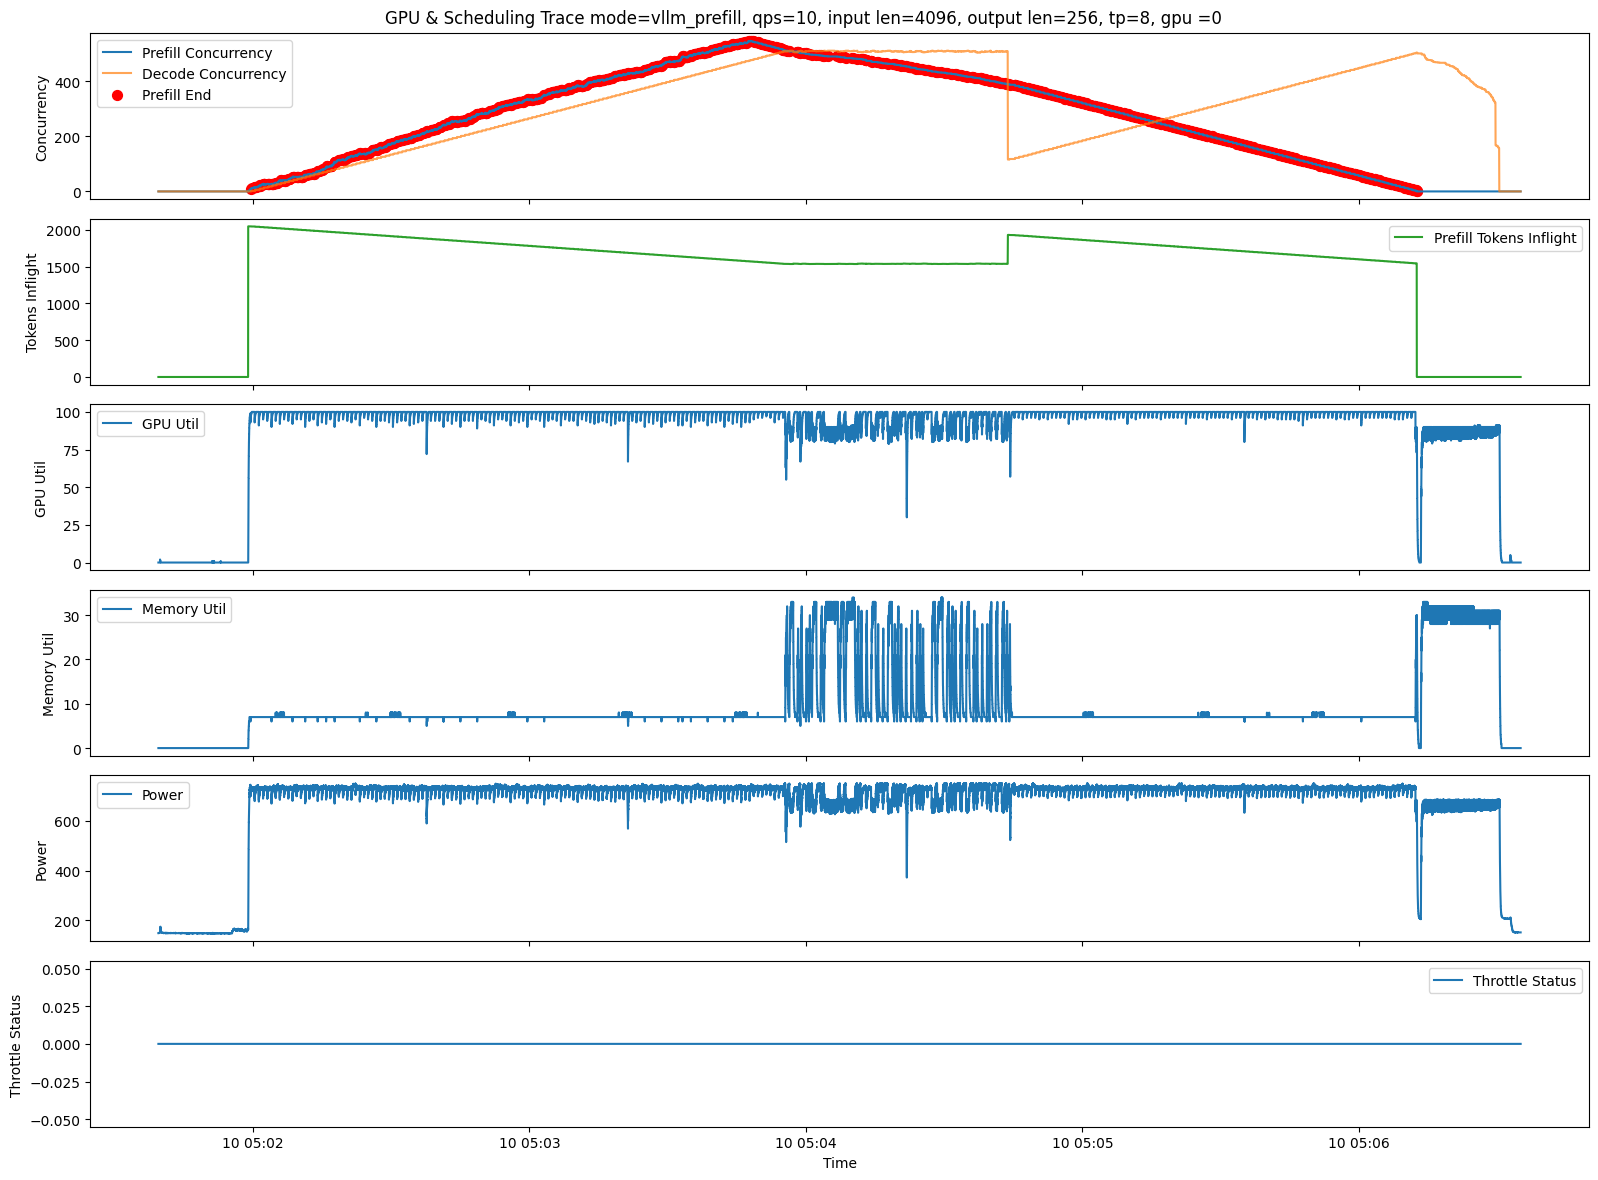

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps10_vllm_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/vllm_prefill-qps-10-input-len-4096-tp-8.json
2025-07-10T05:01:59.521069287
2025-07-10T05:01:59.670809507
2025-07-10T05:02:00.404515743
2025-07-10T05:02:00.541300535
2025-07-10T05:02:00.404453516
2025-07-10T05:02:00.541349649
2025-07-10T05:02:01.479195833
2025-07-10T05:02:01.421133757
2025-07-10T05:02:01.479146242
2025-07-10T05:02:01.421081781
2025-07-10T05:02:02.353735924
2025-07-10T05:02:02.301628113
2025-07-10T05:02:02.353690386
2025-07-10T05:02:02.301680088
2025-07-10T05:02:03.228350639
2025-07-10T05:02:03.388104916
2025-07-10T05:02:03.228413105
2025-07-10T05:02:03.388053656
2025-07-10T05:02:04.111957550
2025-07-10T05:02:04.251831055
2025-07-10T05:02:04.111902714
2025-07-10T05:02:04.251879215
2025-07-10T05:02:04.988343000
2025-07-10T05:02:05.121678114
2025-07-10T05:02:04.988276005
2025-07-10T05:02:05.121617079
2025-07-10T05:02:06.0

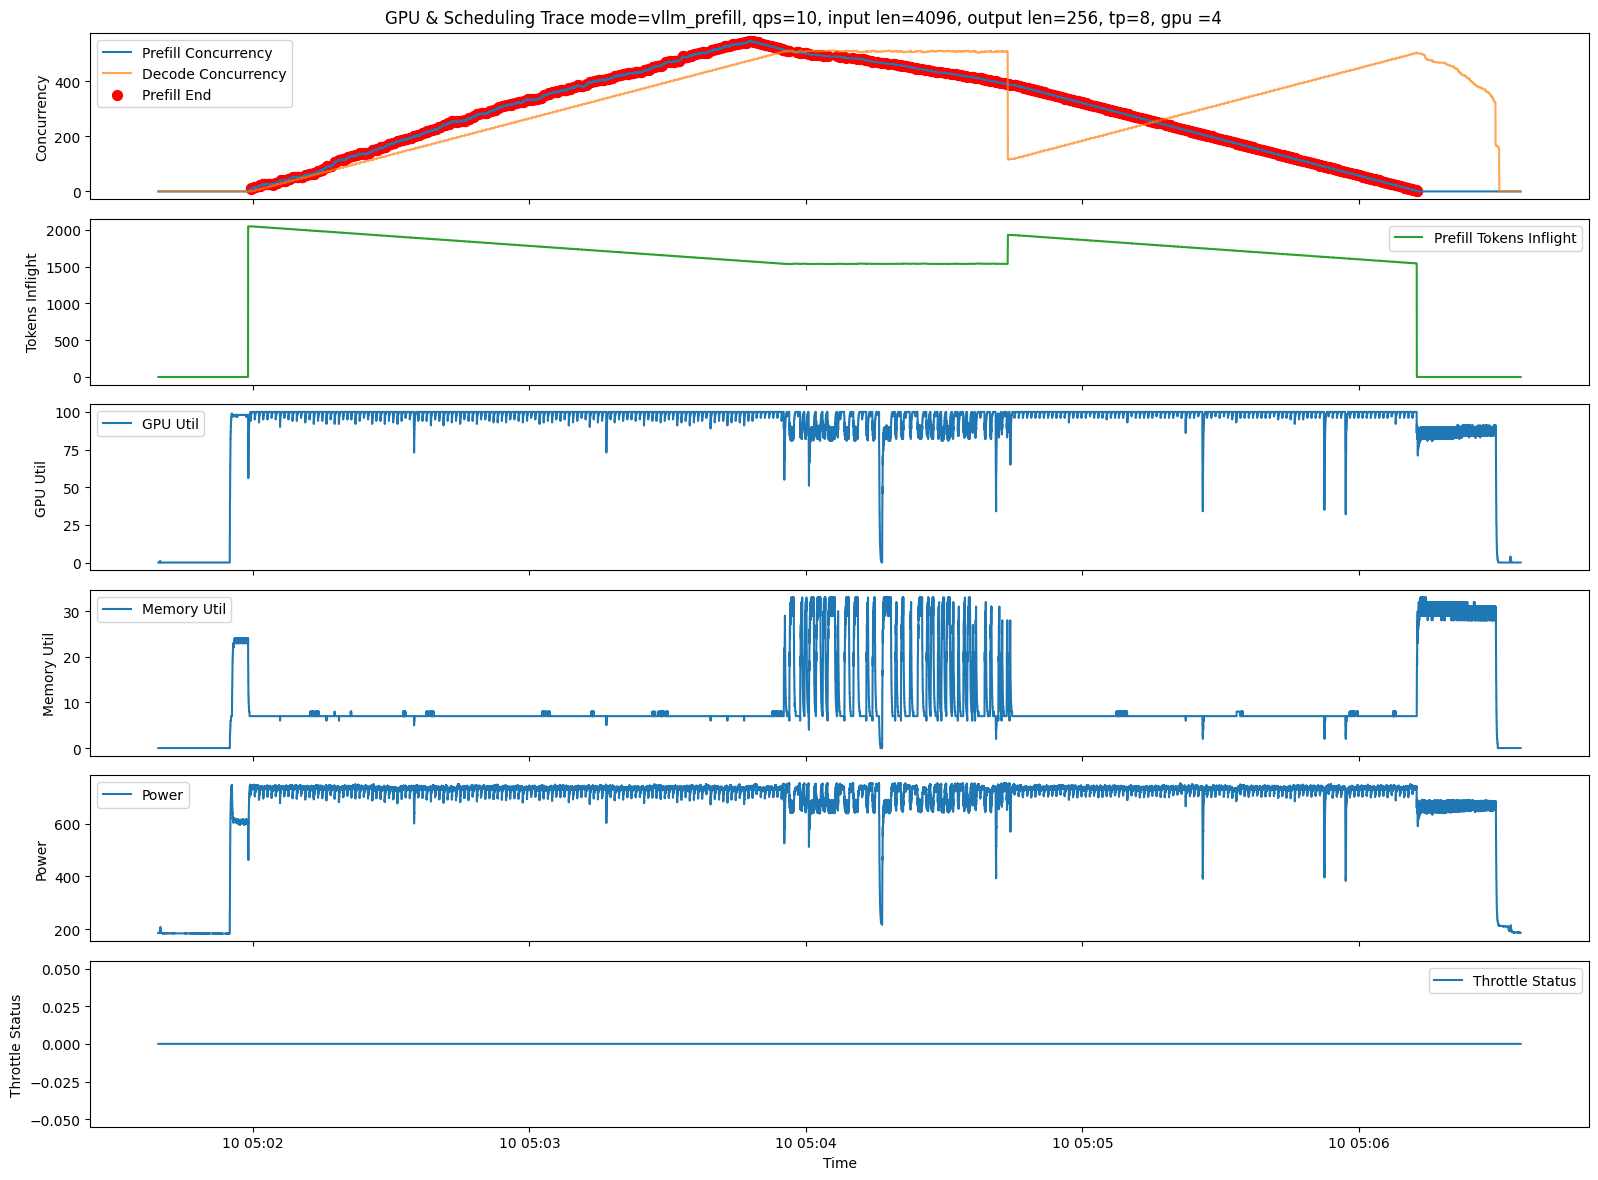

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_chunked_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-20-input-len-4096-tp-8.json
2025-07-09T18:42:45.013103008
2025-07-09T18:42:45.031880617
2025-07-09T18:42:45.553554058
2025-07-09T18:42:45.579682589
2025-07-09T18:42:46.081645012
2025-07-09T18:42:46.112592697
2025-07-09T18:42:46.601214647
2025-07-09T18:42:46.633908272
2025-07-09T18:42:47.054951668
2025-07-09T18:42:47.089471817
2025-07-09T18:42:47.553413153
2025-07-09T18:42:47.543698072
2025-07-09T18:42:48.042857885
2025-07-09T18:42:48.041990995
2025-07-09T18:42:48.524216174
2025-07-09T18:42:48.521530866
2025-07-09T18:42:49.308657169
2025-07-09T18:42:48.994978905
2025-07-09T18:42:49.853624344
2025-07-09T18:42:49.782073498
2025-07-09T18:42:50.387002707
2025-07-09T18:42:50.320470095
2025-07-09T18:42:50.896551847
2025-07-09T18:42:50.844419241
2025-07-09T18:42:51.351342916
2025-07-09T18:42:51.357435226
2025-07-09T18:4

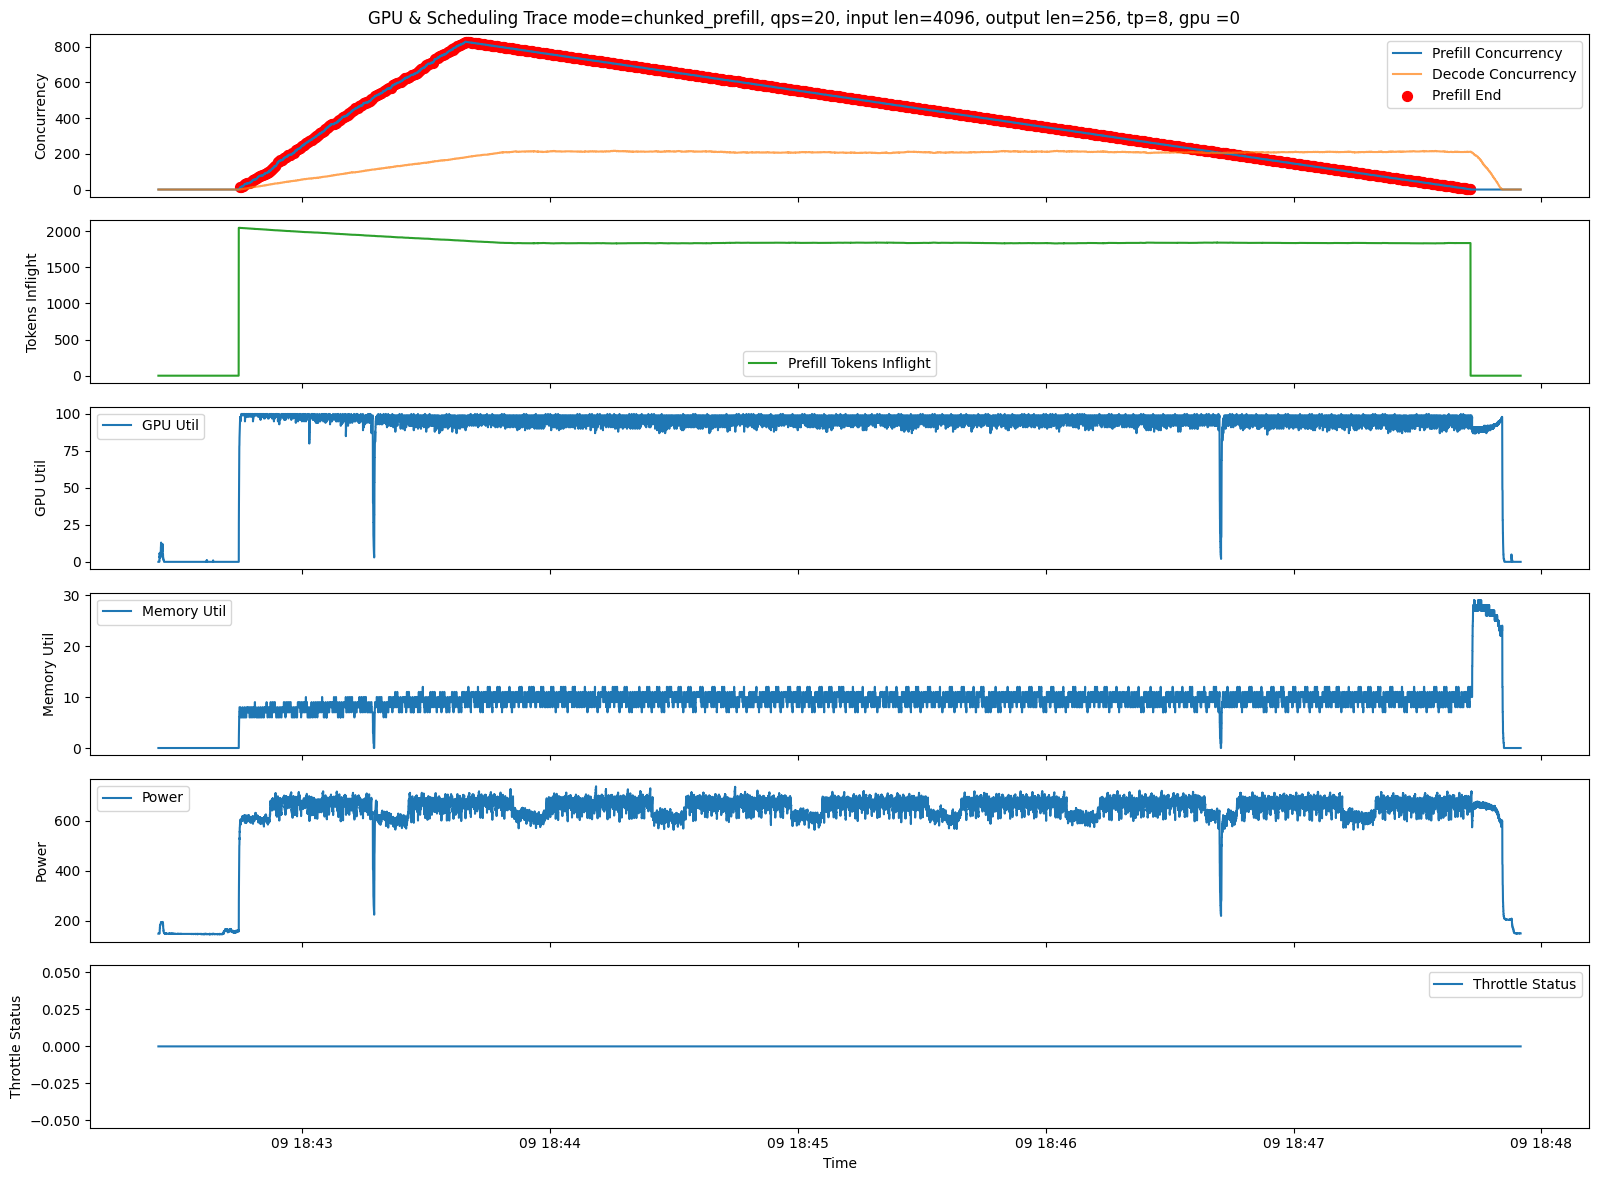

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_chunked_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-20-input-len-4096-tp-8.json
2025-07-09T18:42:45.013103008
2025-07-09T18:42:45.031880617
2025-07-09T18:42:45.553554058
2025-07-09T18:42:45.579682589
2025-07-09T18:42:46.081645012
2025-07-09T18:42:46.112592697
2025-07-09T18:42:46.601214647
2025-07-09T18:42:46.633908272
2025-07-09T18:42:47.054951668
2025-07-09T18:42:47.089471817
2025-07-09T18:42:47.553413153
2025-07-09T18:42:47.543698072
2025-07-09T18:42:48.042857885
2025-07-09T18:42:48.041990995
2025-07-09T18:42:48.524216174
2025-07-09T18:42:48.521530866
2025-07-09T18:42:49.308657169
2025-07-09T18:42:48.994978905
2025-07-09T18:42:49.853624344
2025-07-09T18:42:49.782073498
2025-07-09T18:42:50.387002707
2025-07-09T18:42:50.320470095
2025-07-09T18:42:50.896551847
2025-07-09T18:42:50.844419241
2025-07-09T18:42:51.351342916
2025-07-09T18:42:51.357435226
2025-07-09T18:4

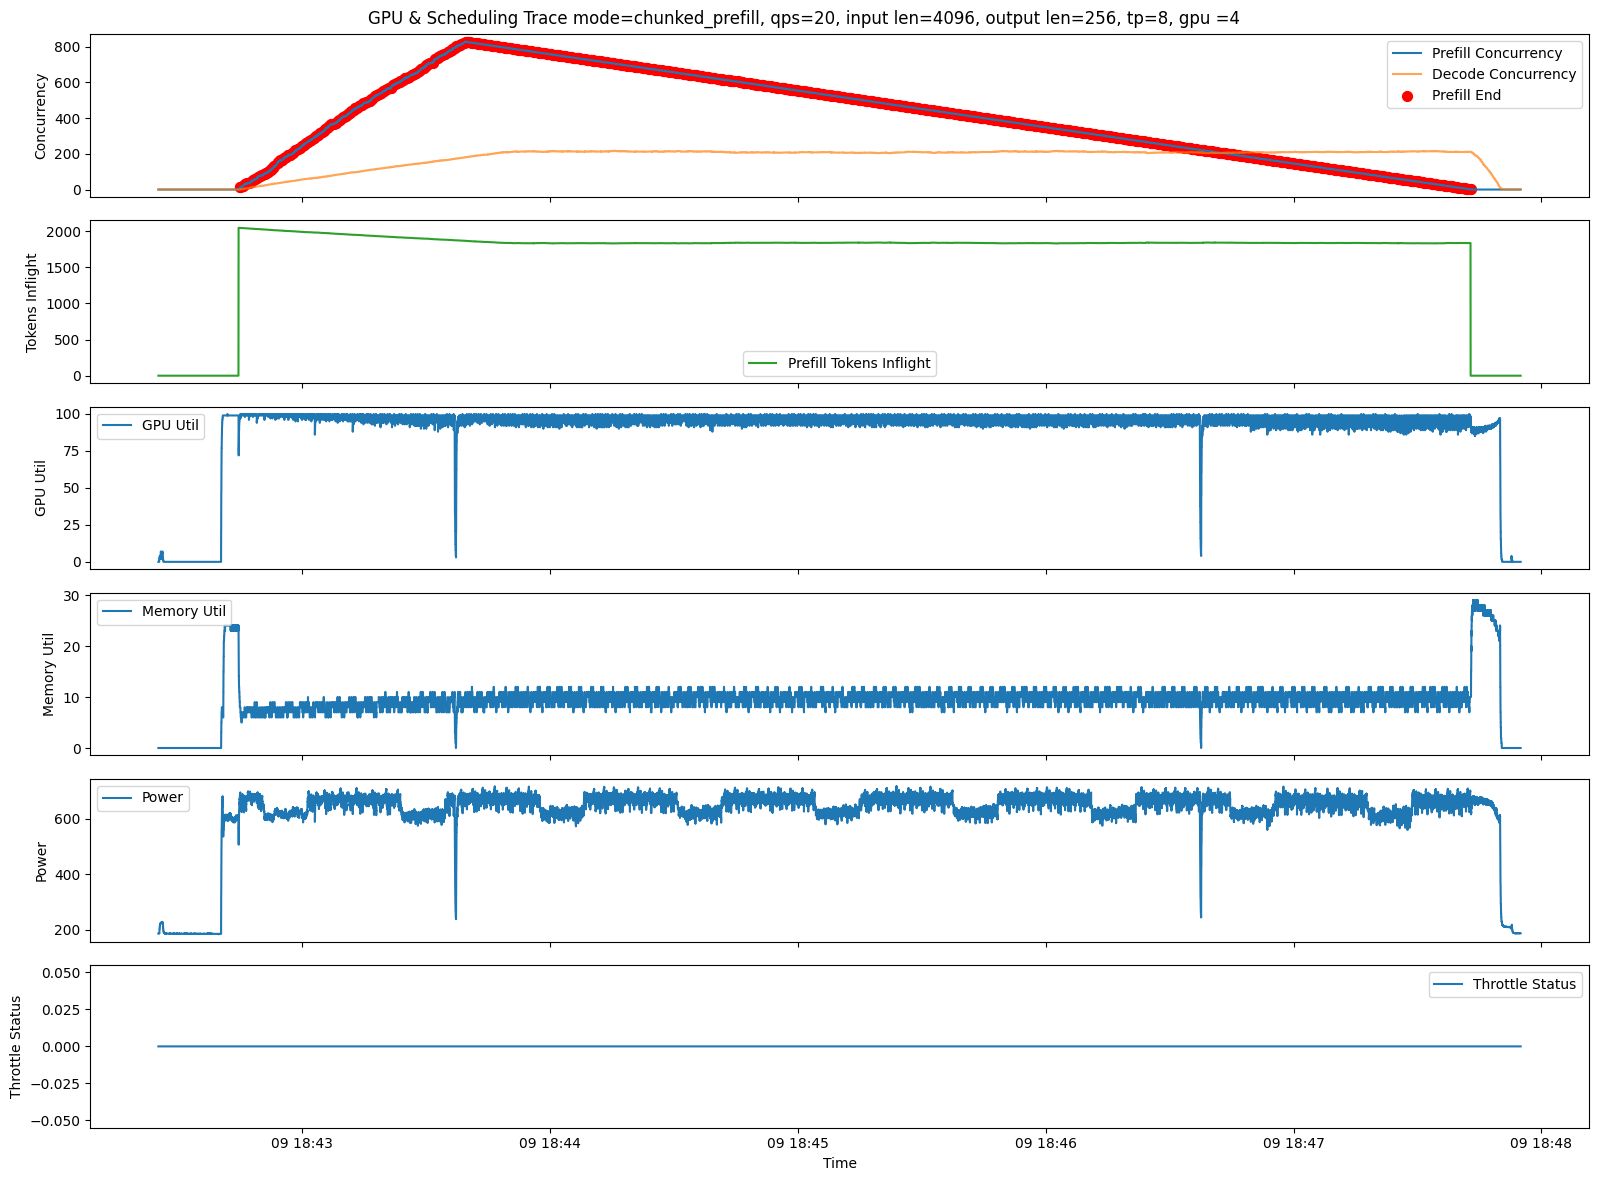

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_disagg_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-20-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_disagg_prefill_tp8_0: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_disagg_prefill_tp8_0'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_disagg_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-20-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_disagg_prefill_tp8_4: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_disagg_prefill_tp8_4'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profili

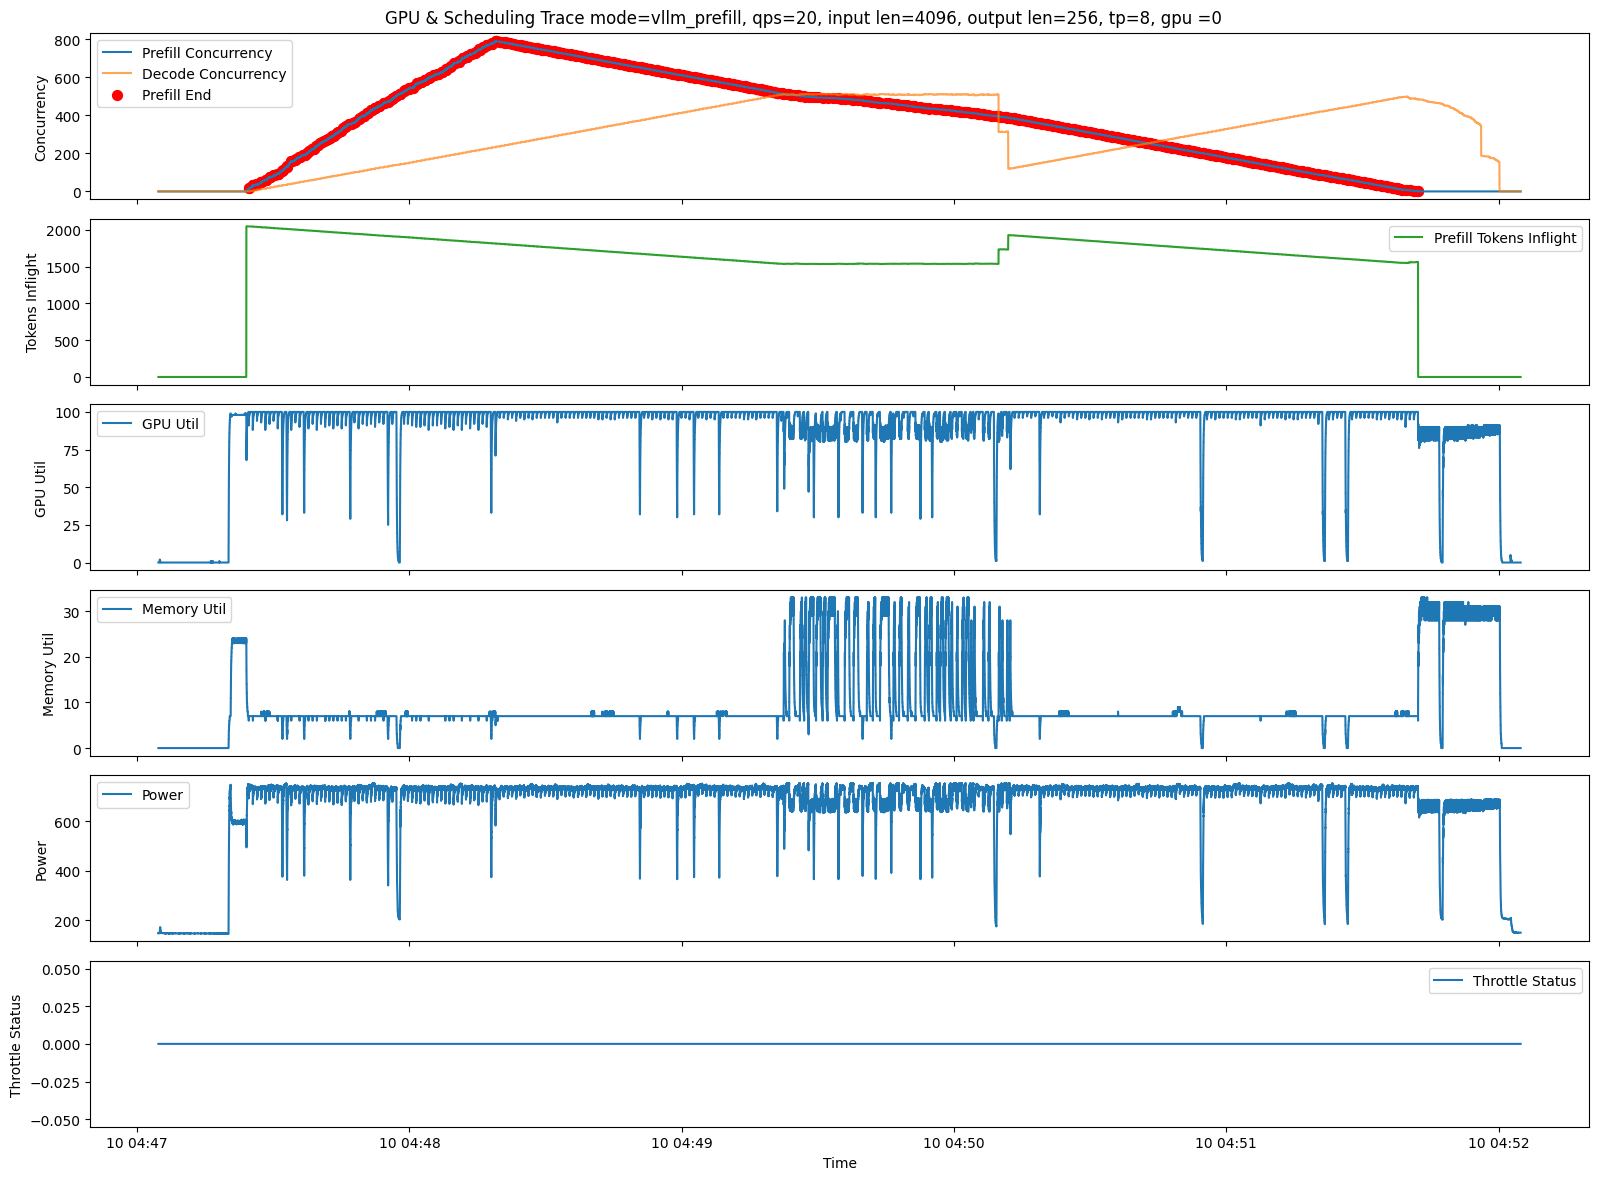

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps20_vllm_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/vllm_prefill-qps-20-input-len-4096-tp-8.json
2025-07-10T04:47:24.722540617
2025-07-10T04:47:24.757544041
2025-07-10T04:47:25.601989031
2025-07-10T04:47:25.634244919
2025-07-10T04:47:25.601919651
2025-07-10T04:47:25.634311199
2025-07-10T04:47:26.477885723
2025-07-10T04:47:26.509352684
2025-07-10T04:47:26.477081776
2025-07-10T04:47:26.509292125
2025-07-10T04:47:27.358271599
2025-07-10T04:47:27.388284445
2025-07-10T04:47:27.358217239
2025-07-10T04:47:27.388221025
2025-07-10T04:47:28.440955400
2025-07-10T04:47:28.483329296
2025-07-10T04:47:28.440888405
2025-07-10T04:47:28.483397722
2025-07-10T04:47:29.324452400
2025-07-10T04:47:29.350957632
2025-07-10T04:47:29.324381590
2025-07-10T04:47:29.351008654
2025-07-10T04:47:30.204724550
2025-07-10T04:47:30.219354630
2025-07-10T04:47:30.204791546
2025-07-10T04:47:30.219412804
2025-07-10T04:47:31.0

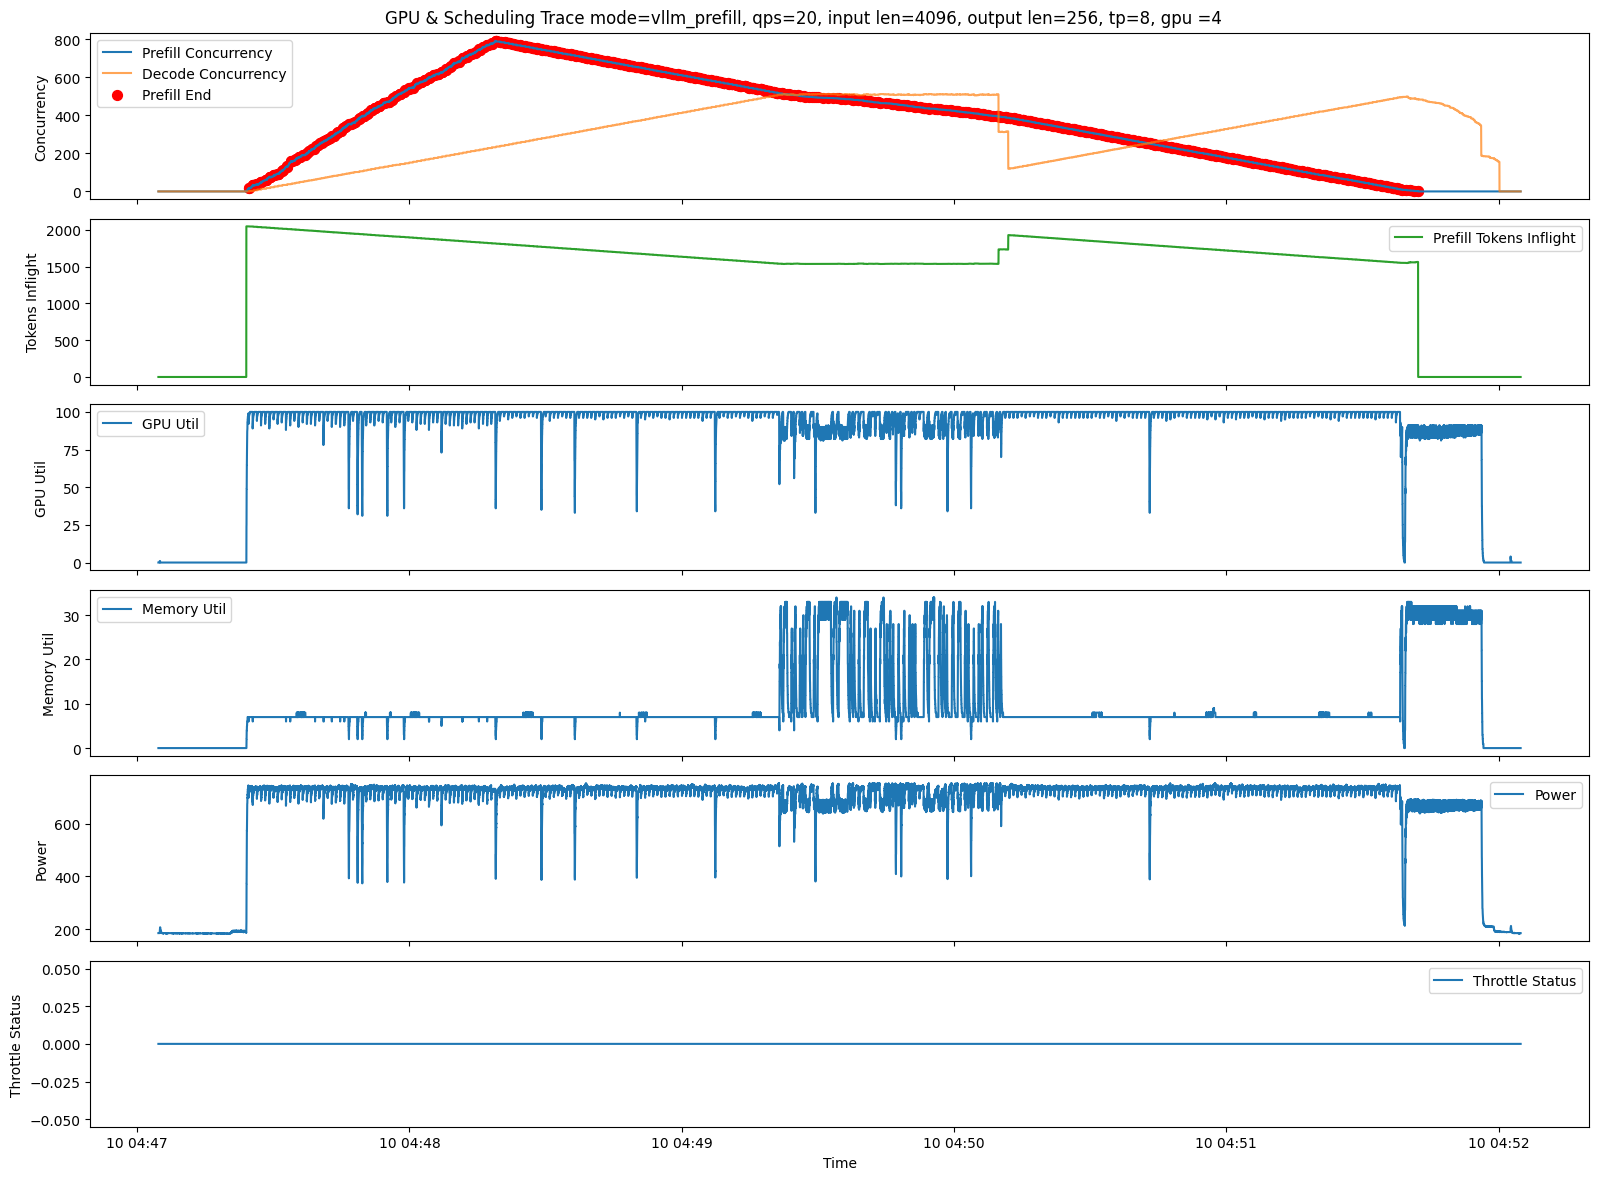

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_chunked_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-50-input-len-4096-tp-8.json
2025-07-09T06:34:29.886716843
2025-07-09T06:34:29.884994268
2025-07-09T06:34:30.432420015
2025-07-09T06:34:30.430658102
2025-07-09T06:34:30.969848633
2025-07-09T06:34:30.962304592
2025-07-09T06:34:31.495233774
2025-07-09T06:34:31.489141464
2025-07-09T06:34:31.955847740
2025-07-09T06:34:31.947335720
2025-07-09T06:34:32.460651875
2025-07-09T06:34:32.405158281
2025-07-09T06:34:32.957671165
2025-07-09T06:34:32.903052807
2025-07-09T06:34:33.446962833
2025-07-09T06:34:33.391617060
2025-07-09T06:34:34.253403425
2025-07-09T06:34:33.873164177
2025-07-09T06:34:34.804235220
2025-07-09T06:34:34.659071922
2025-07-09T06:34:35.355639219
2025-07-09T06:34:35.202605963
2025-07-09T06:34:35.876036406
2025-07-09T06:34:35.734233141
2025-07-09T06:34:36.343483686
2025-07-09T06:34:36.275798798
2025-07-09T06:3

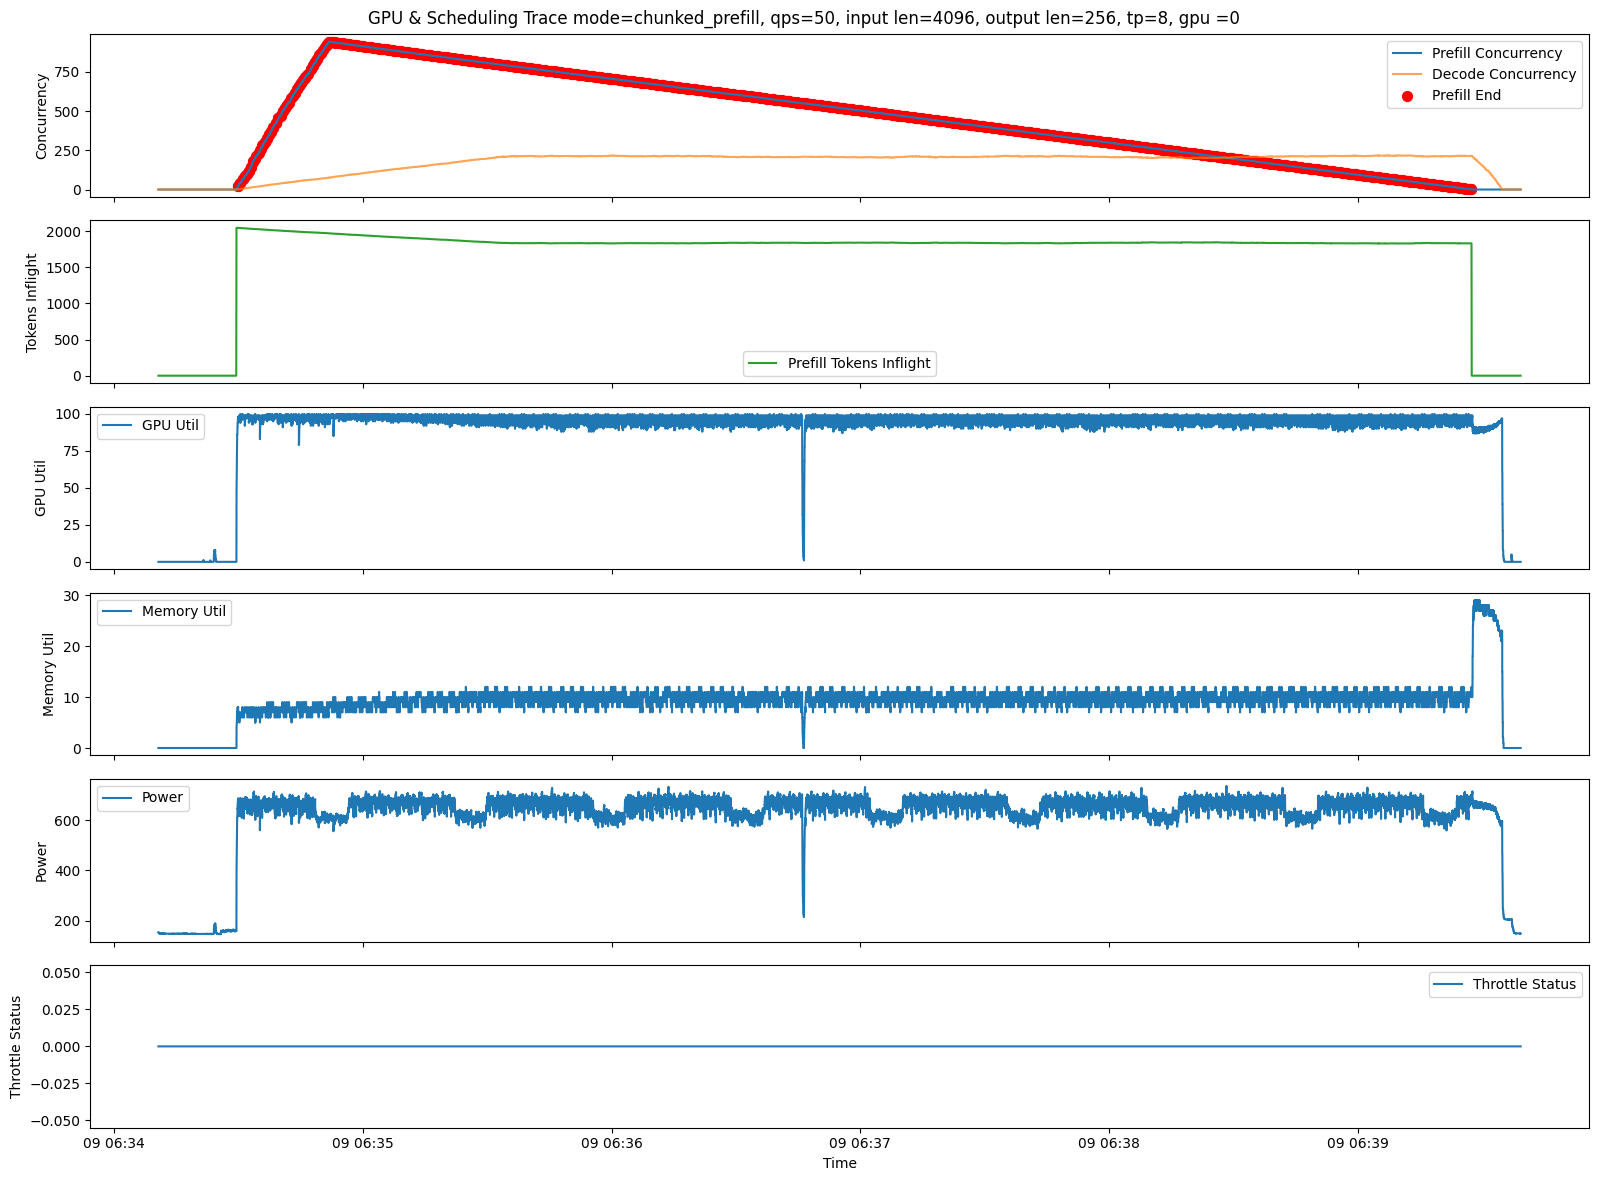

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_chunked_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/chunked_prefill-qps-50-input-len-4096-tp-8.json
2025-07-09T06:34:29.886716843
2025-07-09T06:34:29.884994268
2025-07-09T06:34:30.432420015
2025-07-09T06:34:30.430658102
2025-07-09T06:34:30.969848633
2025-07-09T06:34:30.962304592
2025-07-09T06:34:31.495233774
2025-07-09T06:34:31.489141464
2025-07-09T06:34:31.955847740
2025-07-09T06:34:31.947335720
2025-07-09T06:34:32.460651875
2025-07-09T06:34:32.405158281
2025-07-09T06:34:32.957671165
2025-07-09T06:34:32.903052807
2025-07-09T06:34:33.446962833
2025-07-09T06:34:33.391617060
2025-07-09T06:34:34.253403425
2025-07-09T06:34:33.873164177
2025-07-09T06:34:34.804235220
2025-07-09T06:34:34.659071922
2025-07-09T06:34:35.355639219
2025-07-09T06:34:35.202605963
2025-07-09T06:34:35.876036406
2025-07-09T06:34:35.734233141
2025-07-09T06:34:36.343483686
2025-07-09T06:34:36.275798798
2025-07-09T06:3

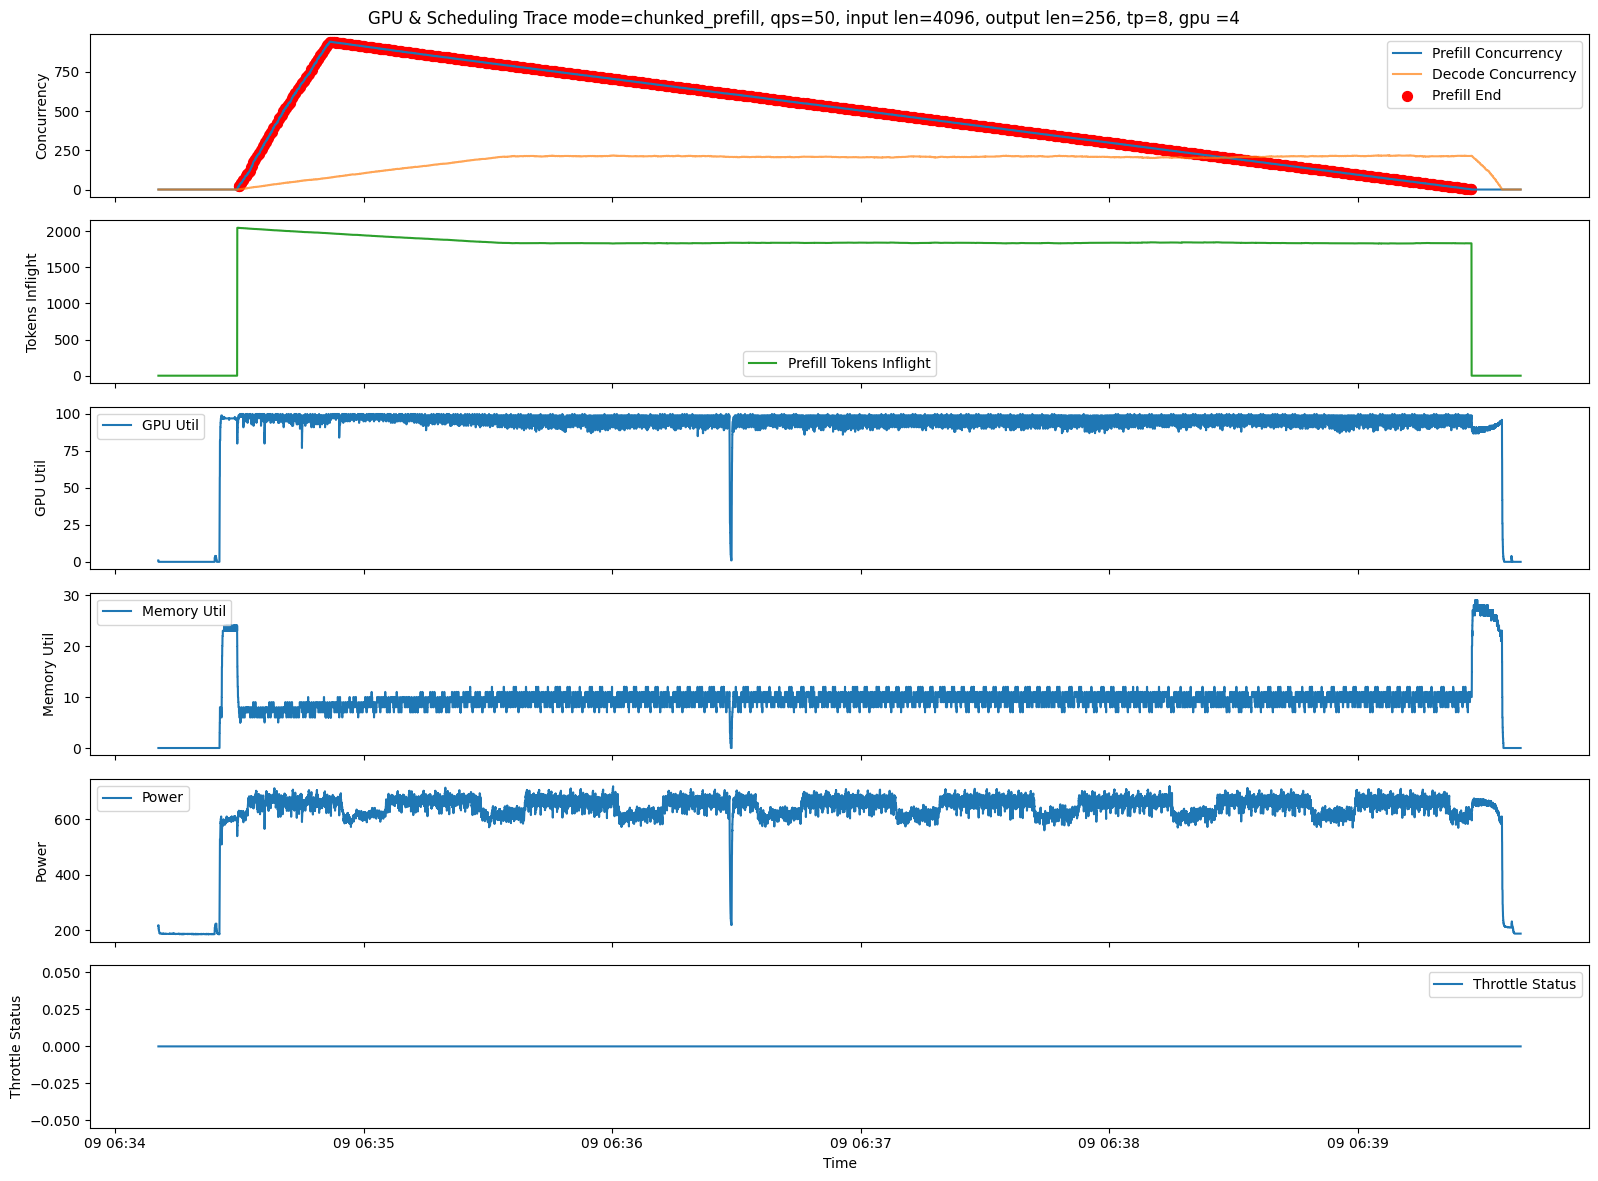

Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_disagg_prefill_tp8_0, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-50-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_disagg_prefill_tp8_0: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_disagg_prefill_tp8_0'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_disagg_prefill_tp8_4, /var/lib/jenkins/vllm/benchmarks/results/disagg_prefill-qps-50-input-len-4096-tp-8.json
Failed for /var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_disagg_prefill_tp8_4: [Errno 2] No such file or directory: '/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data/in4096_qps50_disagg_prefill_tp8_4'
Running: /var/lib/jenkins/vllm/benchmarks/online_serving_results/profili

In [31]:
run_trace_and_plot_all(
    results_dir_csv='/var/lib/jenkins/vllm/benchmarks/online_serving_results/profiling_data',
    results_dir_json='/var/lib/jenkins/vllm/benchmarks/results/',
    fixed_length=4096,
    vary_qps=[1, 10, 20, 50],
)
